In [272]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns

In [273]:
import argparse
import random
import networkx as nx

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from ignite.engine import Engine, Events
#from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [274]:
method = ''
from g2g_model_Fisher import *

In [275]:
data_path = 'data/'
data_name = 'DG_bin_ppt'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
# data_name = 'zebrafish_dynamo_part'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
pca_dim = 50
[k_nei, K, L] = [10, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

result_path = 'action_results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = result_path
cmap = plt.colormaps['Spectral']

In [276]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

folder = os.path.exists(figure_path)
if not folder:
    os.makedirs(figure_path)

In [277]:
from scipy.sparse import csr_matrix
import scanpy as sc
adata = adata0.copy()
sc.pp.pca(adata, n_comps=pca_dim)
sc.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=pca_dim, n_neighbors=k_nei)
scv.tl.velocity(adata)

gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
Xs = adata.layers['Ms'] #adata.X.A#
# Xs = adata.layers['M_s'] #如果是EG_ab_dyn
X = Xs

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc=np.amax(adata.obsp['distances'])
cell_nei=adata.obsp['distances'].indices.reshape([-1,k_nei-1])
nei_w=[]
rho_arr=[]
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [278]:
# from utils import *
# from g2g_model_Fisher import *

# epochs = 400
# nsamples = 5
# learning_rate = 1e-3
# seed = 0
# # n_workers = 4

# if seed is not None:
#     reset_seeds(seed)

# A = A_mat
# A = A.astype(np.float32)
# X = Xs.astype(np.float32)
# z = np.zeros(adata.n_obs)

# n = A.shape[0]
# train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
# A_train = A[train_nodes, :][:, train_nodes]
# X_train = X[train_nodes]
# z_train = z[train_nodes]
# A_val = A[val_nodes, :][:, val_nodes]
# X_val = X[val_nodes]
# z_val = z[val_nodes]

# train_data = AttributedGraph(A_train, X_train, z_train, K)
# val_data = AttributedGraph(A_val, X_val, z_val, K)

# encoder = Encoder(X.shape[1], L)

# optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

# iterations = epochs #// n_workers
# dataset = GraphDataset(train_data, nsamples, iterations)
# loader = DataLoader(
#     dataset,
#     batch_size=1,
# #     num_workers=n_workers,
#     worker_init_fn=reset_seeds,
#     collate_fn=lambda args: args,
# )

# for batch_idx, data in enumerate(loader):
#     encoder.train()
#     optimizer.zero_grad()

#     # compute weighted loss
#     _ ,i,j,k,w,nsamples = data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5]

#     mu, sigma = encoder.forward(data[0][0])

#     mu_i = gather_rows(mu, i)
#     sigma_i = gather_rows(sigma, i)
#     mu_j = gather_rows(mu, j)
#     sigma_j = gather_rows(sigma, j)
#     mu_k = gather_rows(mu, k)
#     sigma_k = gather_rows(sigma, k)

#     diff_ij = mu_i - mu_j
#     ss_ij = sigma_i + sigma_j
#     ds_ij = sigma_i - sigma_j
    
#     closer = 2*((torch.log (
        
#         (torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)+torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)/\
#         torch.abs((torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)-torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)
#         +1e-10)
#             ))**2).sum(axis=-1)

#     diff_ik = mu_i - mu_k
#     ss_ik = sigma_i + sigma_k
#     ds_ik = sigma_i - sigma_k
    
#     apart = 2*((torch.log (
        
#         (torch.sqrt(0.5*diff_ik**2+ss_ik**2+1e-10)+torch.sqrt(0.5*diff_ik**2+ds_ik**2+1e-10)+1e-10)/\
#         torch.abs((torch.sqrt(0.5*diff_ik**2+ss_ik**2+1e-10)-torch.sqrt(0.5*diff_ik**2+ds_ik**2+1e-10)+1e-10)
#         +1e-10)
#             ))**2).sum(axis=-1)

#     # E = closer*weight[i,j] + torch.exp(-torch.sqrt(apart))*weight[i,k] 
#     E = closer + torch.exp(-torch.sqrt(apart)) 

#     loss = E.dot(w) / nsamples
#     if batch_idx% 10 == 0:
#         print(batch_idx,loss)
#     loss.backward()
#     optimizer.step()

# torch.save(encoder,result_path+'encoder.pt')

In [279]:
encoder = torch.load(result_path+'encoder.pt')

In [280]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

Fisher_g_diag = np.zeros([X.shape[0],L*2])
for i in range(X.shape[0]):
    Fisher_g_diag[i] = np.diag(Fisher_g[i])

In [281]:
def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2+1e-12)
    return W_dist

In [282]:
cRc_arr=[]
cRc_arr_eu=[]
A = csr_matrix(A_mat + np.eye(A_mat.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

In [283]:
X_plt = X_pca[:,0]
Y_plt = X_pca[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min-wid*10
Y_ori = Y_min-wid*10

In [322]:
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
velo_pca = velo_g@adata.varm['PCs']
latent_z = np.hstack((mu_learned,sigma_learned))

## **Shortest Fisher Dist Path**

In [285]:
# B = kneighbors_graph(latent_z, k_nei, mode='connectivity', include_self=True)

In [286]:
G = nx.from_scipy_sparse_array(A_mat)

In [287]:
#------use a simple neural network to study dmu/dt and dsigma/dt
latent_z = np.hstack((mu_learned,sigma_learned))


model = nn.Sequential(
    nn.Linear(pca_dim, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=1e-3)

x_in=torch.tensor(X_pca.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(200):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
#     if epoch% 10 == 9:
#         print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

pZ_pX = np.zeros([X.shape[0], L*2, X_pca.shape[1]])

# Compute the gradients
for i in range(X.shape[0]):
    x0=torch.tensor(X_pca[i,:],requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX[i,j,:] = x0.grad.detach()

# Z_velo = np.array([pZ_pX[i]@velo_pca[i] for i in range(X.shape[0])])

# zv2 = np.zeros(X.shape[0])
# for i in range(X.shape[0]):
#     for j in range(L):
#         # zv2[i] += Fisher_g[i,2*j,2*j]*Z_velo[i,2*j]**2 + Fisher_g[i,2*j+1,2*j+1]*Z_velo[i,2*j+1]**2
#         zv2[i] += Fisher_g[i,j,j]*Z_velo[i,j]**2 + Fisher_g[i,L+j,L+j]*Z_velo[i,L+j]**2
# zv1 = np.sqrt(zv2)
# zv1_smooth = smooth_func(zv1)

In [288]:
## Smoothing Fisher_g, velo_pca and velo_latent
for i in range(Fisher_g.shape[1]):
    for j in range(Fisher_g.shape[2]): 
        Fisher_g[:,i,j] = smooth_func(Fisher_g[:,i,j]) 

velo_latent = np.zeros([X.shape[0],2*L])
for i in range(X.shape[0]):
    velo_latent[i,:] = pZ_pX[i,:,:] @ velo_pca[i,:]

for i in range(2*L):
    velo_latent[:,i] = smooth_func(velo_latent[:,i])
for i in range(velo_pca.shape[1]):
    velo_pca[:,i] = smooth_func(velo_pca[:,i])

In [289]:
for i in np.array(G.edges):
    G.edges[i]['dist_fisher'] = Fisher_distz(latent_z[i[0]],latent_z[i[1]])
    G.edges[i]['dist_euclidean'] = np.linalg.norm(X_pca[i[0],:]-X_pca[i[1],:])
    G.edges[i]['action'] = (latent_z[i[1]]-latent_z[i[0]]).T@Fisher_g[i[0]]@(latent_z[i[1]]-latent_z[i[0]])

In [290]:
def path_len(G, dist, path):
    lenp = 0
    for i in range(len(path)-1):
        lenp += G.edges[path[i],path[i+1]][dist]
    return lenp

In [291]:
# DG try 1091 -> 1546
ng = 100
sources = np.array([np.random.choice(G.nodes) for _ in range(ng)])
# targets = np.array([np.random.choice(G.nodes) for _ in range(ng)])
targets = np.array([np.argmax(np.array([Fisher_distz(latent_z[j], latent_z[sources[i]]) for j in range(X.shape[0])]),axis=0) for i in range(ng)])

In [292]:
# 让路径总是顺着伪时间方向
cell_vpt = adata.obs['palantir_pseudotime']
for i in range(ng):
    if cell_vpt[sources[i]] > cell_vpt[targets[i]]:
        tmp = sources[i]
        sources[i] = targets[i]
        targets[i] = tmp

In [293]:
spz_euc = [nx.shortest_path(G,source=sources[i],target=targets[i],weight='dist_euclidean') for i in range(ng)]
spz_fisher = [nx.shortest_path(G,source=sources[i],target=targets[i],weight='dist_fisher') for i in range(ng)]
spz_action = [nx.shortest_path(G,source=sources[i],target=targets[i],weight='action') for i in range(ng)]
    


## 这里保存的图片，用的是结果文件夹里面的sources，targets做的
# for i in range(ng):
#     idx = ~np.isnan(crc_smooth)
#     cmap = plt.colormaps['Spectral']
#     plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
#     clb=plt.colorbar()
#     clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
#     clb.ax.tick_params(axis='y', labelsize=15)
#     # plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')
#     plt.axis('off')
#     plt.plot(X_plt[spz_euc[i]],Y_plt[spz_euc[i]],c='purple', linewidth=2, label='least Euclidean dist')
#     plt.plot(X_plt[spz_fisher[i]],Y_plt[spz_fisher[i]],c='black', linewidth=2, label='least Fisher dist')
#     plt.plot(X_plt[spz_action[i]],Y_plt[spz_action[i]],c='brown', linewidth=2, label='least Fisher action')
#     plt.scatter(X_plt[spz_action[i][0]],Y_plt[spz_action[i][0]], color='red', s=50, label='Start')
#     plt.scatter(X_plt[spz_action[i][-1]],Y_plt[spz_action[i][-1]], color='blue', s=50, label='End')
#     plt.legend(loc = 'best')



#     plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
#     plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
#     plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
#     plt.text(X_ori-wid*25,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')
#     plt.savefig(result_path+f'path{i}.png')
#     plt.show()

In [298]:
# 不要重复保存！
# np.save(result_path+'sources',sources)
# np.save(result_path+'targets',targets)

# 后来用来画corr分布图的保存如下
# np.save(result_path+'sources100',sources)
# np.save(result_path+'targets100',targets)

## **Correlation of RNA Velo and Shortest Path direction**

In [299]:
Fisher_pca = np.zeros((X.shape[0],pca_dim, pca_dim))
for i in range(X.shape[0]):
    Fisher_pca[i] = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]

eigs_pca = np.zeros((X.shape[0],pca_dim))
eigvecs_pca = np.zeros((X.shape[0],pca_dim, pca_dim))
for i in range(X.shape[0]):
    eig, eigvec = np.linalg.eig(Fisher_pca[i])
    sorted_indices = np.argsort(eig)[::-1]  # 从大到小排序
    eigs_pca[i] = eig[sorted_indices]
    eigvecs_pca[i] = eigvec[sorted_indices]

**PCA**

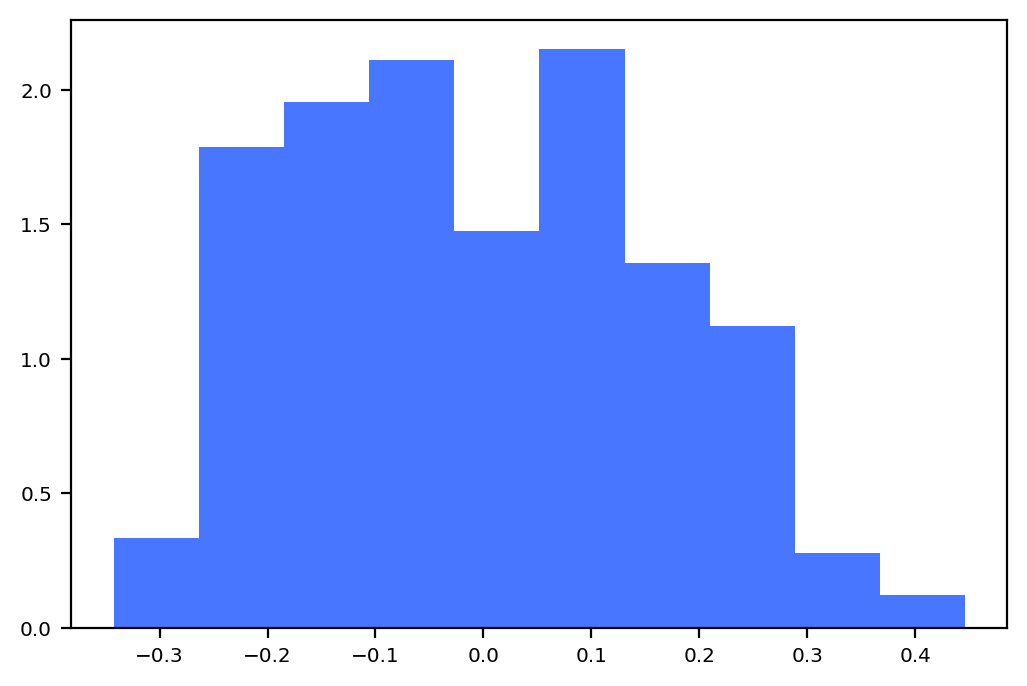

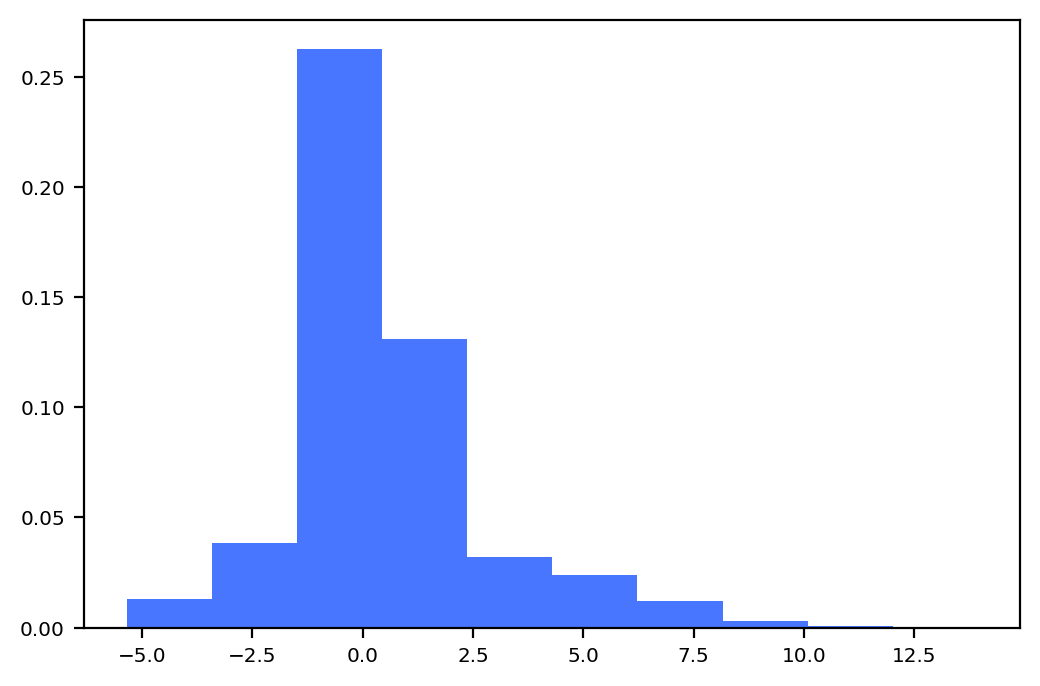

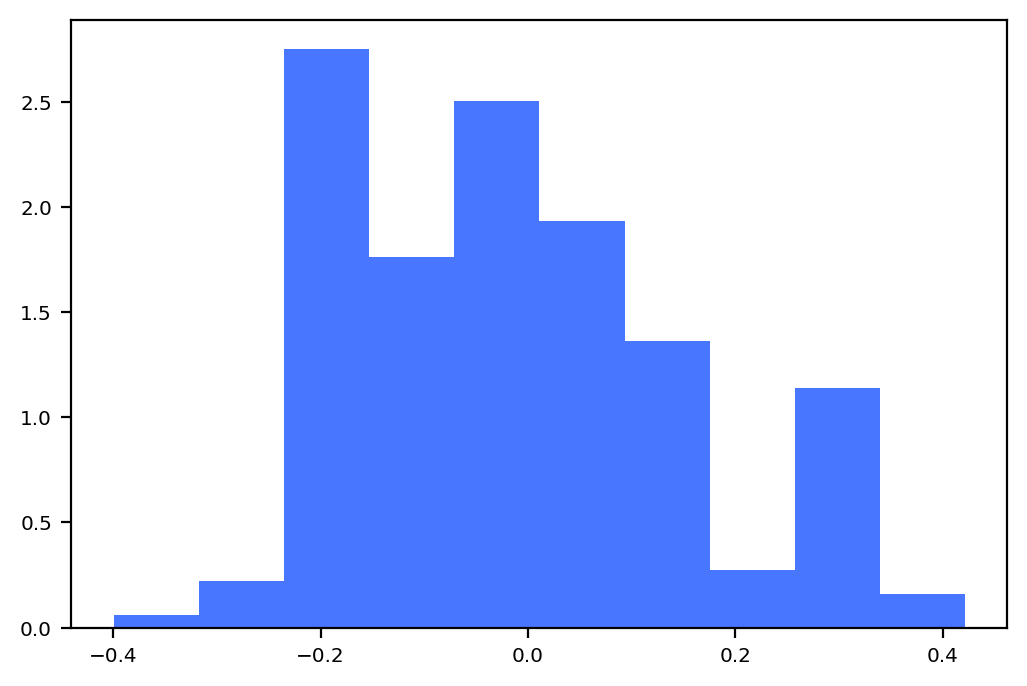

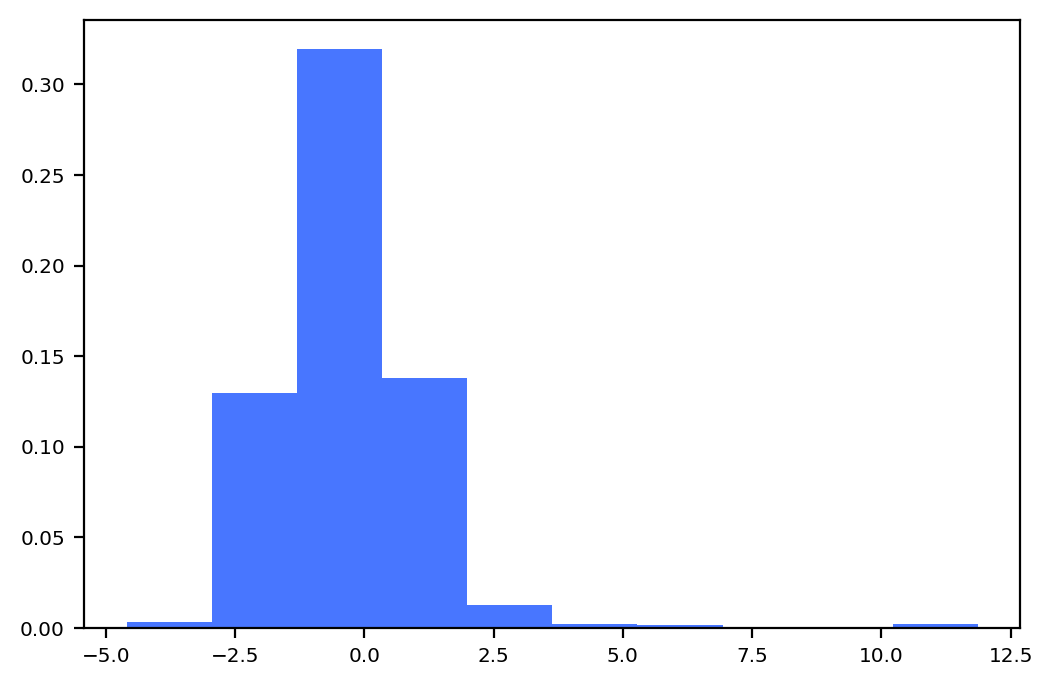

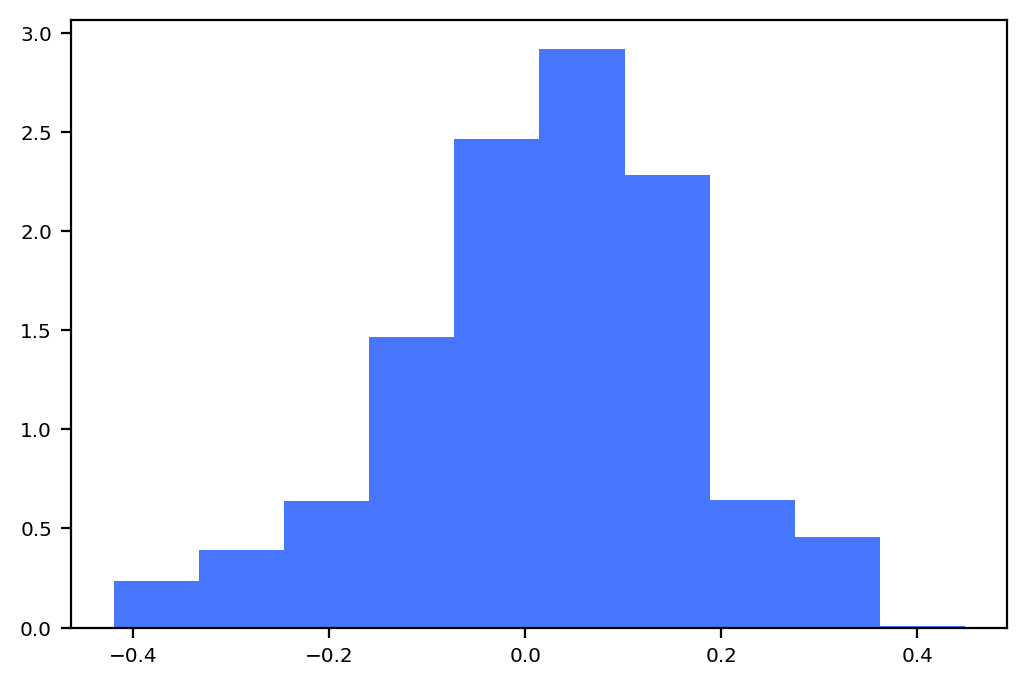

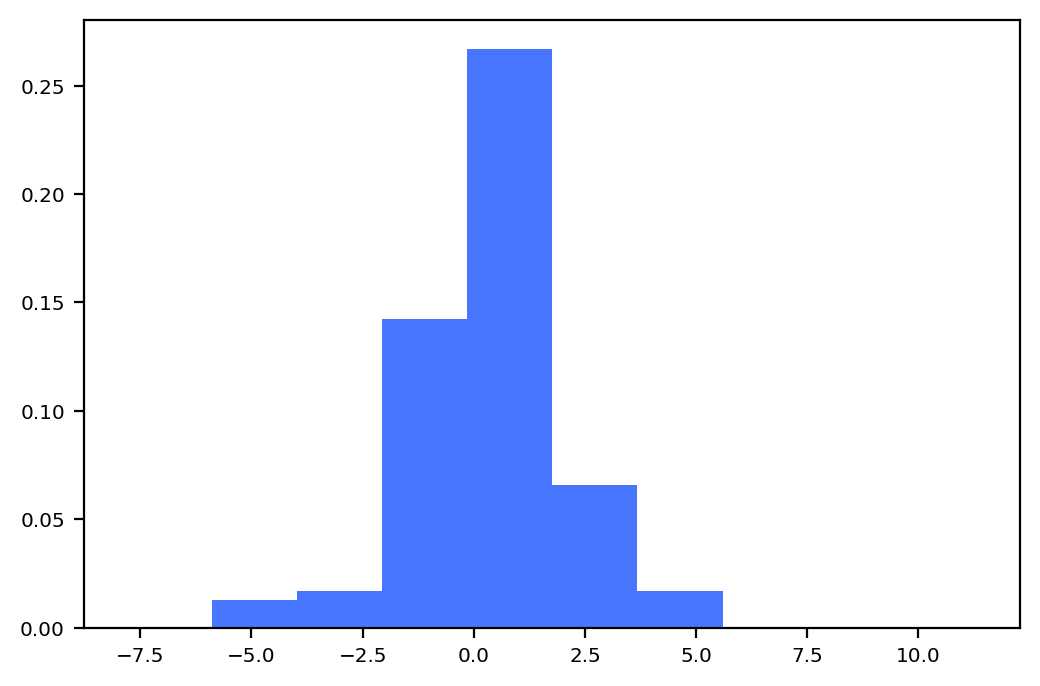

-0.009821604578979687 0.002173639357000818 0.01995019939572145 0.025272329484484088 0.02587921817555059 0.021585070278023453
-0.20644026080671615 0.37856257579657215 0.3086836531006874 1.6596307581553038 4.955522326276676 2.589297141313742


In [311]:
v_spz_fisher = [[X_pca[spz_fisher[j][i+1]] - X_pca[spz_fisher[j][i]] for i in range(len(spz_fisher[j])-1)] for j in range(ng)]
# v_pca = velo_pca[spz_fisher[0][:-1]]

corr_fisher = []
inner_prod_fisher = []
for j in range(ng):
    v_pca = velo_pca[spz_fisher[j][:-1]]
    for i in range(len(spz_fisher[j])-1):
        corr_fisher.append(np.corrcoef(v_spz_fisher[j][i],v_pca[i])[0,1])
        inner_prod_fisher.append(np.dot(v_spz_fisher[j][i],v_pca[i]))
plt.hist(np.array(corr_fisher),density=True)
plt.savefig('corr_fisher_dist.png')
plt.show()
plt.hist(np.array(inner_prod_fisher),density=True)
plt.savefig('dot_fisher_dist.png')
plt.show()


v_spz_euc = [[X_pca[spz_euc[j][i+1]] - X_pca[spz_euc[j][i]] for i in range(len(spz_euc[j])-1)] for j in range(ng)]
# v_pca = velo_pca[spz_fisher[0][:-1]]

corr_euc = []
inner_prod_euc = []
for j in range(ng):
    v_pca = velo_pca[spz_euc[j][:-1]]
    for i in range(len(spz_euc[j])-1):
        corr_euc.append(np.corrcoef(v_spz_euc[j][i],v_pca[i])[0,1])
        inner_prod_euc.append(np.dot(v_spz_euc[j][i],v_pca[i]))
plt.hist(np.array(corr_euc),density=True)
plt.savefig('corr_euc_dist.png')
plt.show()
plt.hist(np.array(inner_prod_euc),density=True)
plt.savefig('dot_euc_dist.png')
plt.show()


v_spz_action = [[X_pca[spz_action[j][i+1]] - X_pca[spz_action[j][i]] for i in range(len(spz_action[j])-1)] for j in range(ng)]
# v_pca = velo_pca[spz_fisher[0][:-1]]

corr_action = []
inner_prod_action = []
for j in range(ng):
    v_pca = velo_pca[spz_action[j][:-1]]
    for i in range(len(spz_action[j])-1):
        corr_action.append(np.corrcoef(v_spz_action[j][i],v_pca[i])[0,1])
        inner_prod_action.append(np.dot(v_spz_action[j][i],v_pca[i]))
plt.hist(np.array(corr_action),density=True)
plt.savefig('corr_action.png')
plt.show()
plt.hist(np.array(inner_prod_action),density=True)
plt.savefig('dot_action.png')
plt.show()

print(
    np.mean(corr_euc), np.mean(corr_fisher), np.mean(corr_action), np.var(corr_euc), np.var(corr_fisher), np.var(corr_action)
    )

print(
    np.mean(inner_prod_euc), np.mean(inner_prod_fisher), np.mean(inner_prod_action), np.var(inner_prod_euc), np.var(inner_prod_fisher), np.var(inner_prod_action)
    )

**PCA with Fisher metric**

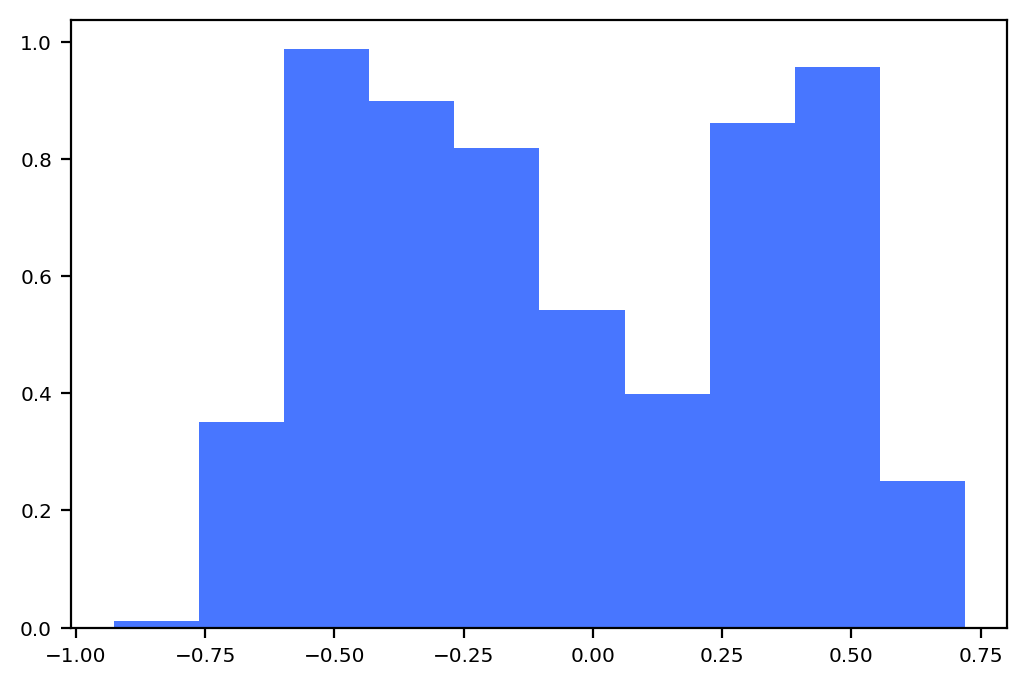

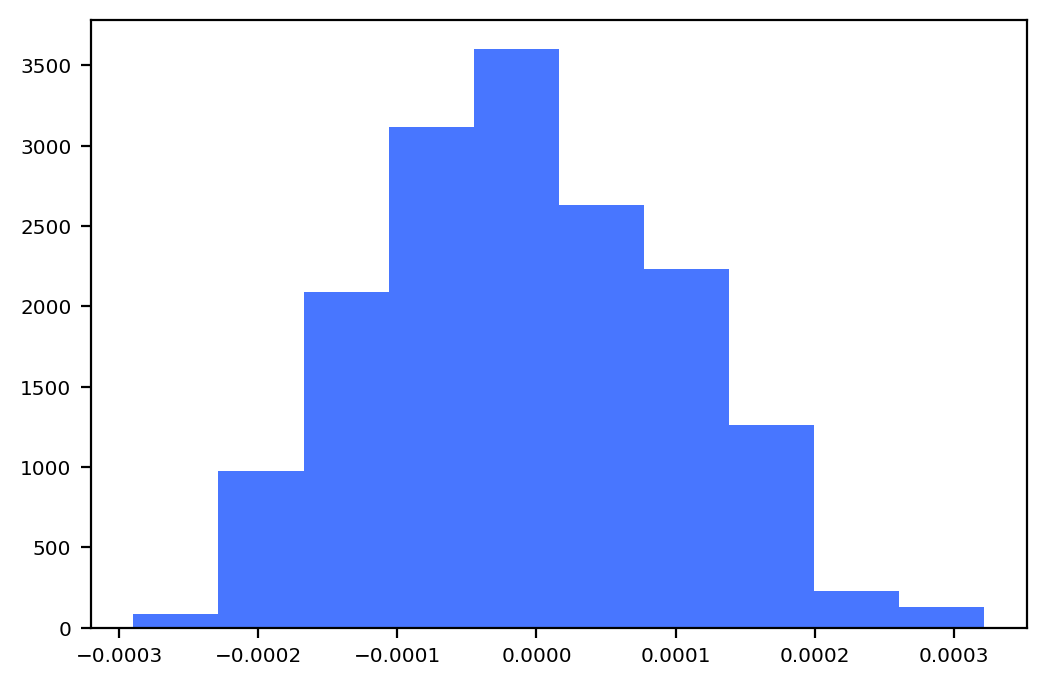

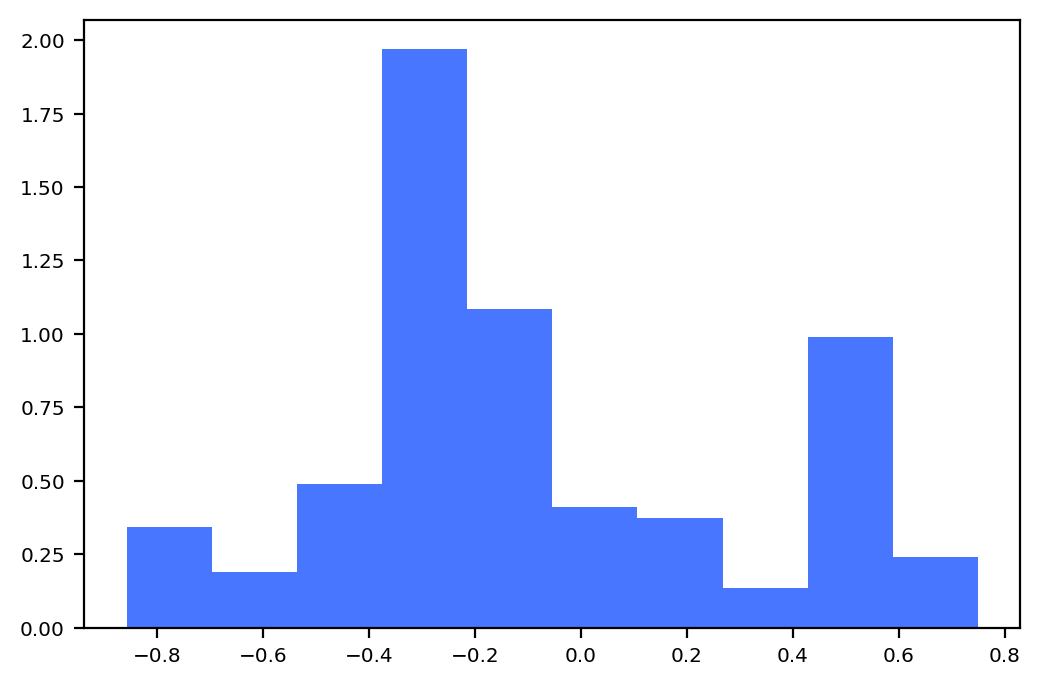

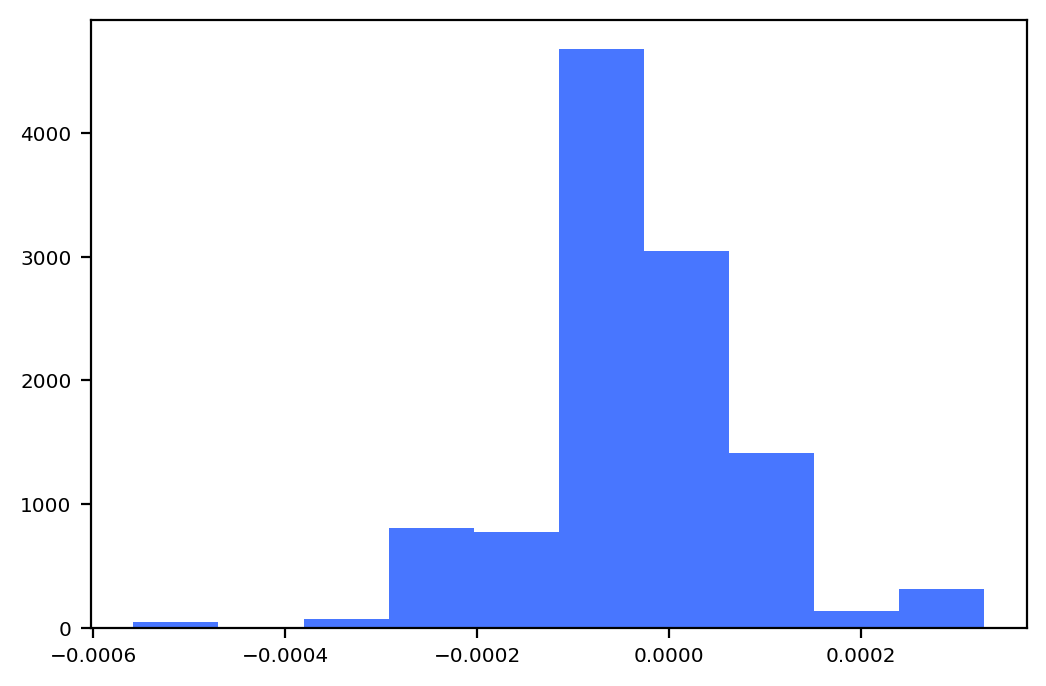

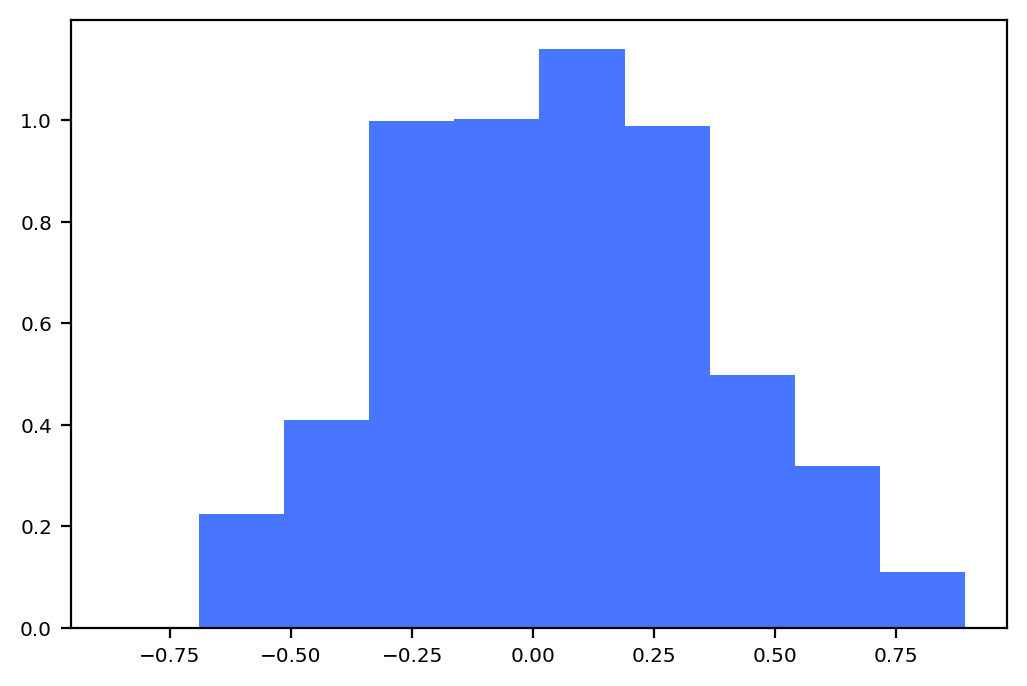

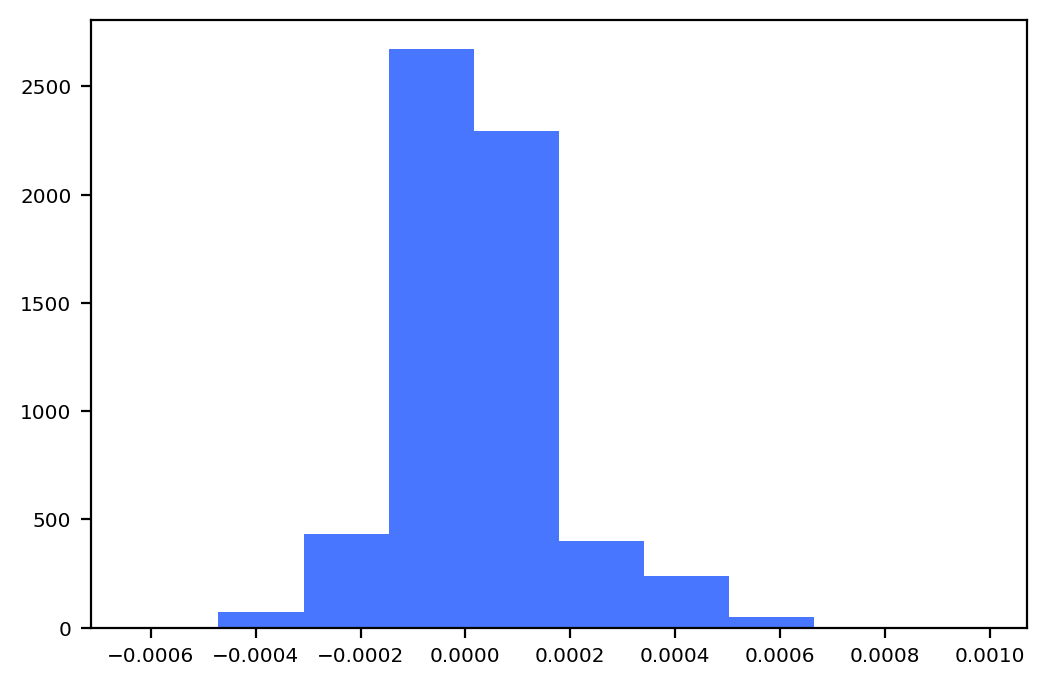

-0.10173586695939477 -0.046929520782474525 0.046177873685184466 0.13972339247873805 0.16862643792687 0.11131383656399173
-3.3932940482329825e-05 -9.788839162621595e-06 2.742886571557324e-05 1.264579963152763e-08 1.1600475713637395e-08 2.276715278838783e-08


In [312]:
# PCA相关系数计算引入内积结构

v_spz_fisher_pca = [[X_pca[spz_fisher[j][i+1]] - X_pca[spz_fisher[j][i]] for i in range(len(spz_fisher[j])-1)] for j in range(ng)]

corr_fisher_pca = []
inner_prod_fisher_pca = []
for j in range(ng):
    v_latent = velo_latent[spz_fisher[j][:-1]]
    for i in range(len(spz_fisher[j])-1):
        corr_fisher_pca.append(np.corrcoef(v_spz_fisher_pca[j][i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_fisher[j][i]])),v_pca[i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_fisher[j][i]])))[0,1])
        inner_prod_fisher_pca.append(np.dot(v_spz_fisher_pca[j][i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_fisher[j][i]])),v_pca[i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_fisher[j][i]]))))
        
plt.hist(np.array(corr_fisher_pca),density=True)
plt.savefig('corr_fisher_dist_pca.png')
plt.show()
plt.hist(np.array(inner_prod_fisher_pca),density=True)
plt.savefig('dot_fisher_dist_pca.png')
plt.show()


v_spz_euc_pca = [[X_pca[spz_euc[j][i+1]] - X_pca[spz_euc[j][i]] for i in range(len(spz_euc[j])-1)] for j in range(ng)]

corr_euc_pca = []
inner_prod_euc_pca = []
for j in range(ng):
    v_latent = velo_latent[spz_euc[j][:-1]]
    for i in range(len(spz_euc[j])-1):
        corr_euc_pca.append(np.corrcoef(v_spz_euc_pca[j][i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_euc[j][i]])),v_pca[i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_euc[j][i]])))[0,1])
        inner_prod_euc_pca.append(np.dot(v_spz_euc_pca[j][i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_euc[j][i]])),v_pca[i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_euc[j][i]]))))
plt.hist(np.array(corr_euc_pca),density=True)
plt.savefig('corr_euc_dist_pca.png')
plt.show()
plt.hist(np.array(inner_prod_euc_pca),density=True)
plt.savefig('dot_euc_dist_pca.png')
plt.show()


v_spz_action_pca = [[X_pca[spz_action[j][i+1]] - X_pca[spz_action[j][i]] for i in range(len(spz_action[j])-1)] for j in range(ng)]

corr_action_pca = []
inner_prod_action_pca = []
for j in range(ng):
    v_pca = velo_pca[spz_action[j][:-1]]
    for i in range(len(spz_action[j])-1):
        corr_action_pca.append(np.corrcoef(v_spz_action_pca[j][i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_action[j][i]])),v_pca[i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_action[j][i]])))[0,1])
        inner_prod_action_pca.append(np.dot(v_spz_action_pca[j][i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_action[j][i]])),v_pca[i]@np.real(scipy.linalg.sqrtm(Fisher_pca[spz_action[j][i]]))))
plt.hist(np.array(corr_action_pca),density=True)
plt.savefig('corr_action_pca.png')
plt.show()
plt.hist(np.array(inner_prod_action_pca),density=True)
plt.savefig('dot_action_pca.png')
plt.show()

print(
    np.mean(corr_euc_pca), np.mean(corr_fisher_pca), np.mean(corr_action_pca),np.var(corr_euc_pca), np.var(corr_fisher_pca), np.var(corr_action_pca)
    )

print(
    np.mean(inner_prod_euc_pca), np.mean(inner_prod_fisher_pca), np.mean(inner_prod_action_pca),np.var(inner_prod_euc_pca), np.var(inner_prod_fisher_pca), np.var(inner_prod_action_pca)
    )

**Latent**

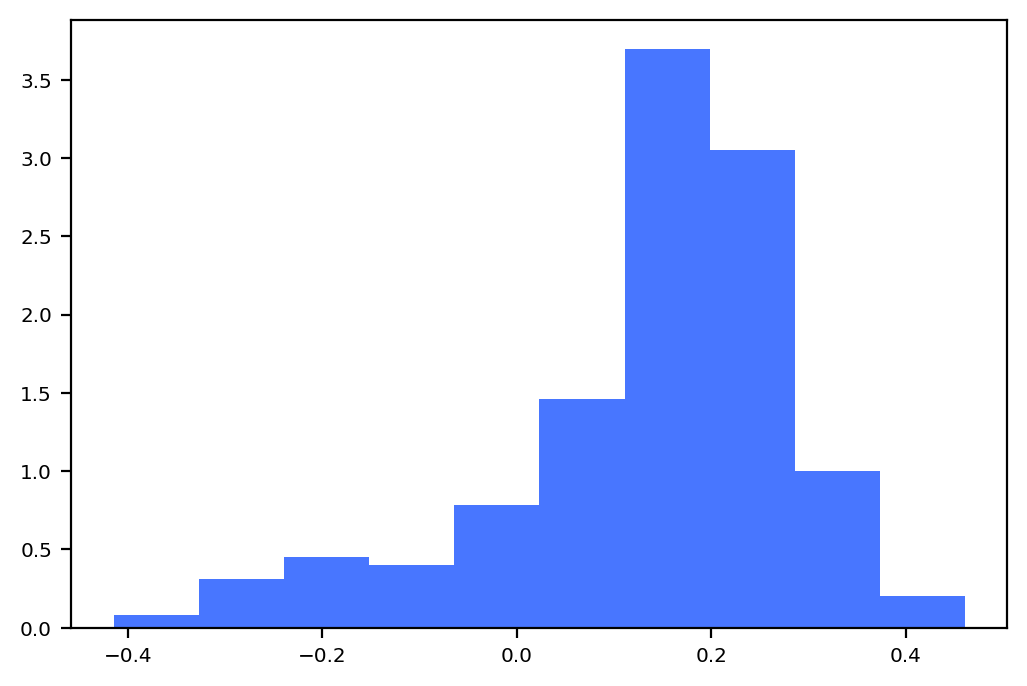

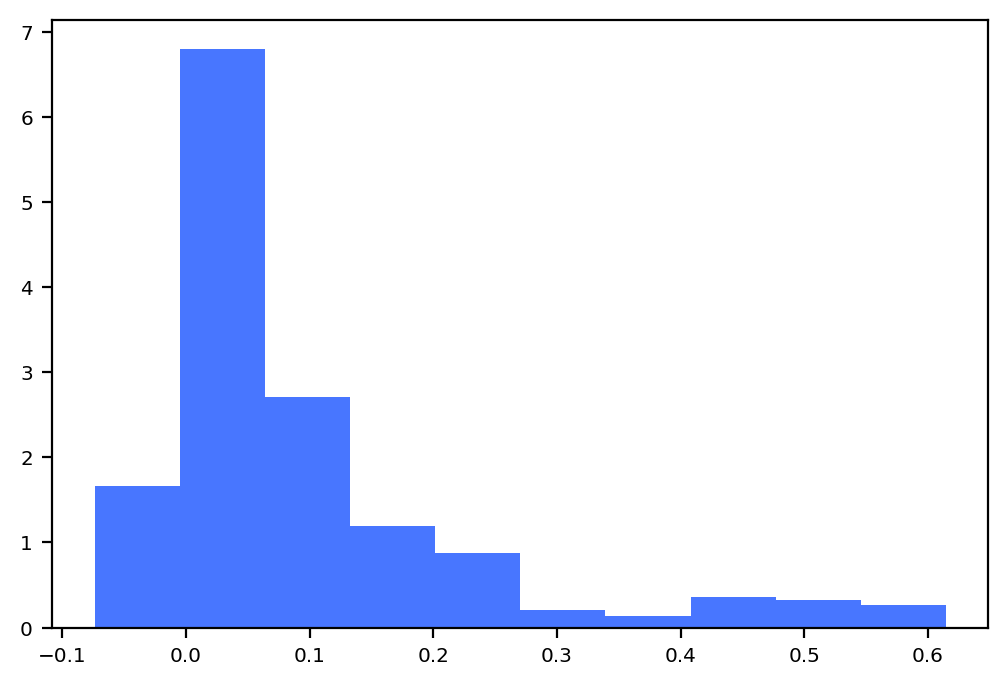

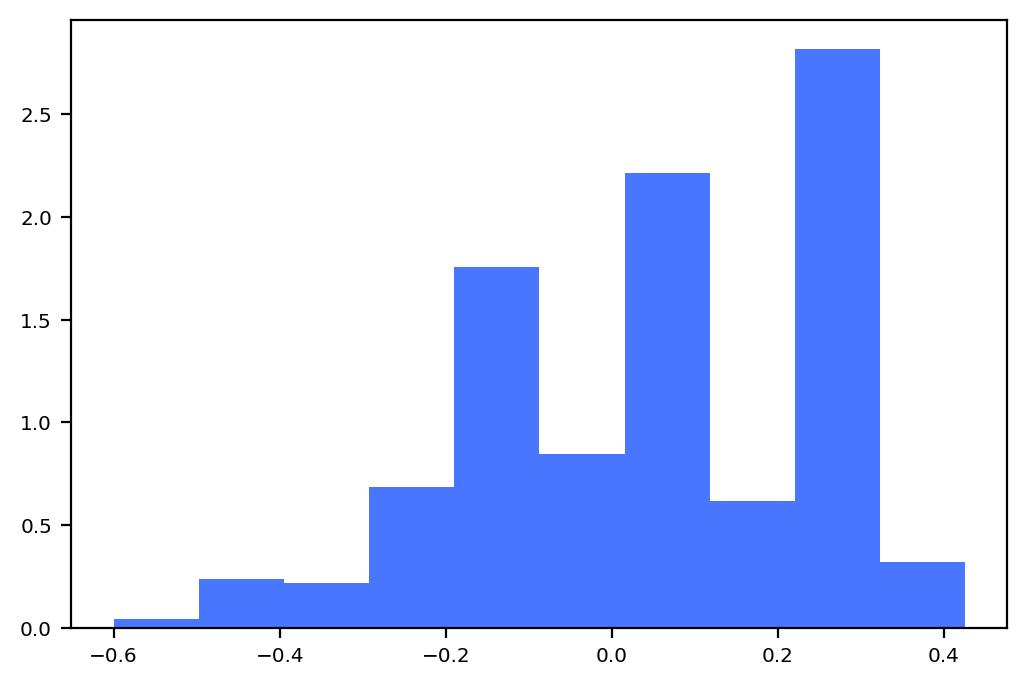

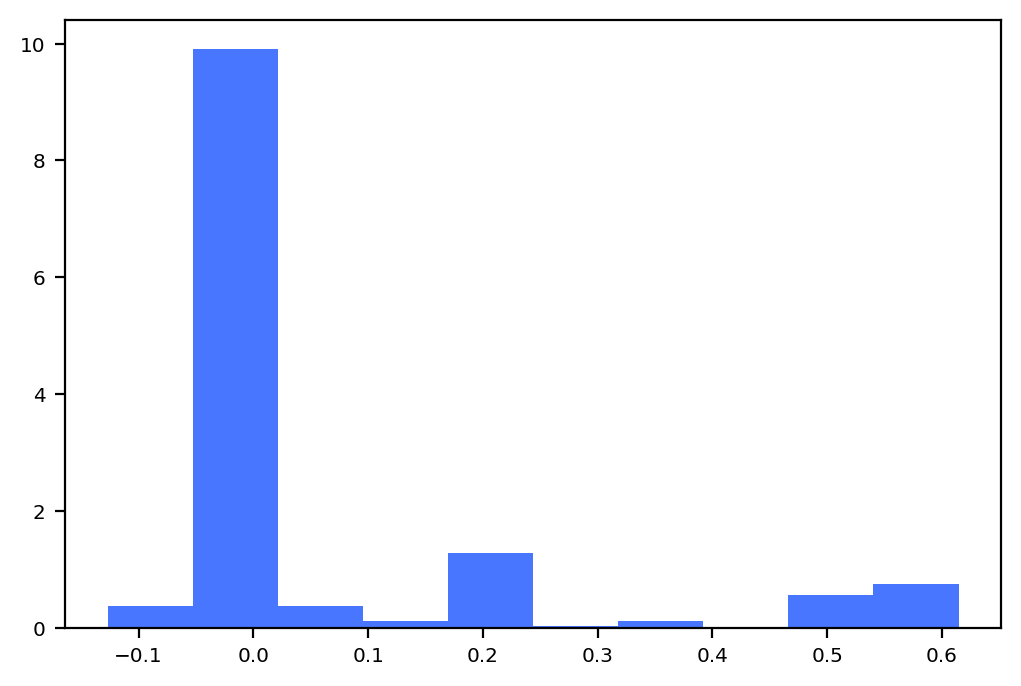

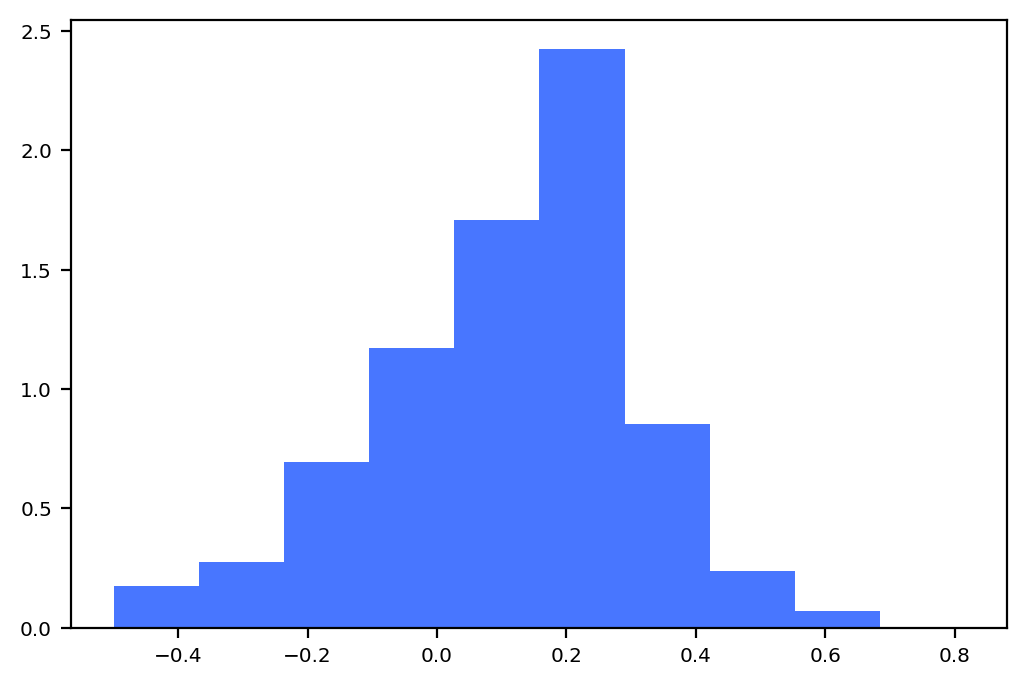

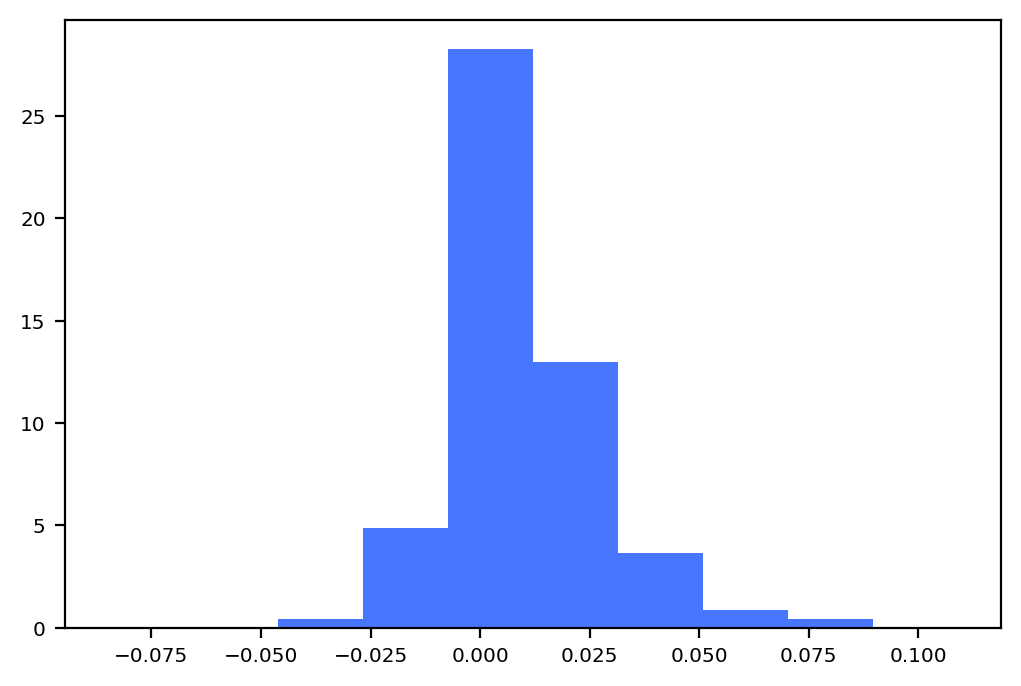

0.04553876222456468 0.13784880291958296 0.10523399415586394 0.04123535045746632 0.02208264511199383 0.039433034970606955
0.07380061011533263 0.09234946199755559 0.009586535043454759 0.03096752416677375 0.01856961601808649 0.00030261575328544065


In [313]:
v_spz_fisher_latent = [[latent_z[spz_fisher[j][i+1]] - latent_z[spz_fisher[j][i]] for i in range(len(spz_fisher[j])-1)] for j in range(ng)]

corr_fisher_latent = []
inner_prod_fisher_latent = []
for j in range(ng):
    v_latent = velo_latent[spz_fisher[j][:-1]]
    for i in range(len(spz_fisher[j])-1):
        # corr_fisher_latent.append(np.corrcoef(v_spz_fisher_latent[j][i]@(Fisher_g[spz_fisher[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_fisher[j][i]])**(1/2))[0,1])
        # inner_prod_fisher_latent.append(np.dot(v_spz_fisher_latent[j][i]@(Fisher_g[spz_fisher[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_fisher[j][i]])**(1/2)))
        corr_fisher_latent.append(np.corrcoef(v_spz_fisher_latent[j][i],v_latent[i])[0,1])
        inner_prod_fisher_latent.append(np.dot(v_spz_fisher_latent[j][i],v_latent[i]))
plt.hist(np.array(corr_fisher_latent),density=True)
plt.savefig('corr_fisher_dist_latent.png')
plt.show()
plt.hist(np.array(inner_prod_fisher_latent),density=True)
plt.savefig('dot_fisher_dist_latent.png')
plt.show()


v_spz_euc_latent = [[latent_z[spz_euc[j][i+1]] - latent_z[spz_euc[j][i]] for i in range(len(spz_euc[j])-1)] for j in range(ng)]

corr_euc_latent = []
inner_prod_euc_latent = []
for j in range(ng):
    v_latent = velo_latent[spz_euc[j][:-1]]
    for i in range(len(spz_euc[j])-1):
        # corr_euc_latent.append(np.corrcoef(v_spz_euc_latent[j][i]@(Fisher_g[spz_euc[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_euc[j][i]])**(1/2))[0,1])
        # inner_prod_euc_latent.append(np.dot(v_spz_euc_latent[j][i]@(Fisher_g[spz_euc[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_euc[j][i]])**(1/2)))
        corr_euc_latent.append(np.corrcoef(v_spz_euc_latent[j][i],v_latent[i])[0,1])
        inner_prod_euc_latent.append(np.dot(v_spz_euc_latent[j][i],v_latent[i]))
plt.hist(np.array(corr_euc_latent),density=True)
plt.savefig('corr_euc_dist_latent.png')
plt.show()
plt.hist(np.array(inner_prod_euc_latent),density=True)
plt.savefig('dot_euc_dist_latent.png')
plt.show()


v_spz_action_latent = [[latent_z[spz_action[j][i+1]] - latent_z[spz_action[j][i]] for i in range(len(spz_action[j])-1)] for j in range(ng)]

corr_action_latent = []
inner_prod_action_latent = []
for j in range(ng):
    v_latent = velo_latent[spz_action[j][:-1]]
    for i in range(len(spz_action[j])-1):
        # corr_action_latent.append(np.corrcoef(v_spz_action_latent[j][i]@(Fisher_g[spz_action[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_action[j][i]])**(1/2))[0,1])
        # inner_prod_action_latent.append(np.dot(v_spz_action_latent[j][i]@(Fisher_g[spz_action[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_action[j][i]])**(1/2)))
        corr_action_latent.append(np.corrcoef(v_spz_action_latent[j][i],v_latent[i])[0,1])
        inner_prod_action_latent.append(np.dot(v_spz_action_latent[j][i],v_latent[i]))
plt.hist(np.array(corr_action_latent),density=True)
plt.savefig('corr_action_latent.png')
plt.show()
plt.hist(np.array(inner_prod_action_latent),density=True)
plt.savefig('dot_action_latent.png')
plt.show()

print(
    np.mean(corr_euc_latent), np.mean(corr_fisher_latent), np.mean(corr_action_latent),np.var(corr_euc_latent), np.var(corr_fisher_latent), np.var(corr_action_latent)
    )

print(
    np.mean(inner_prod_euc_latent), np.mean(inner_prod_fisher_latent), np.mean(inner_prod_action_latent),np.var(inner_prod_euc_latent), np.var(inner_prod_fisher_latent), np.var(inner_prod_action_latent)
    )

**Latent with metric**

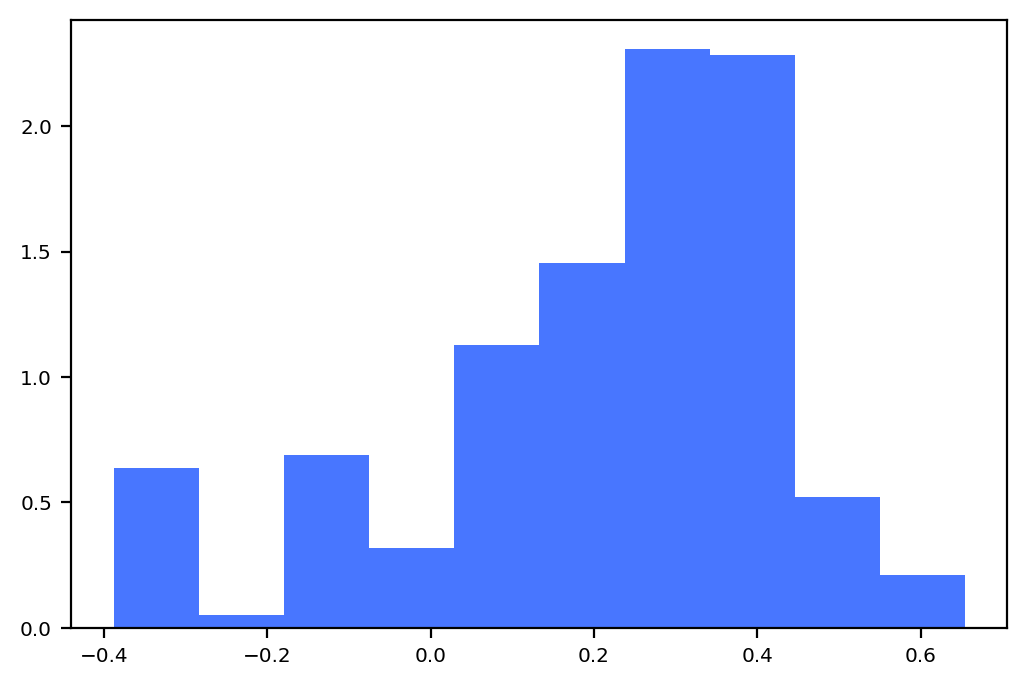

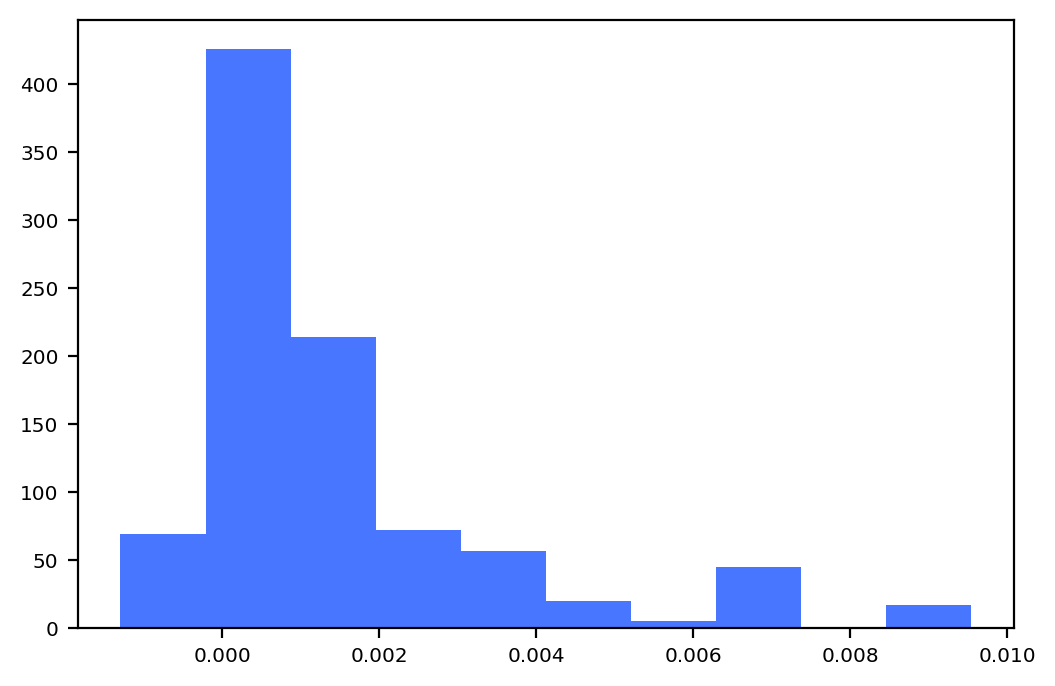

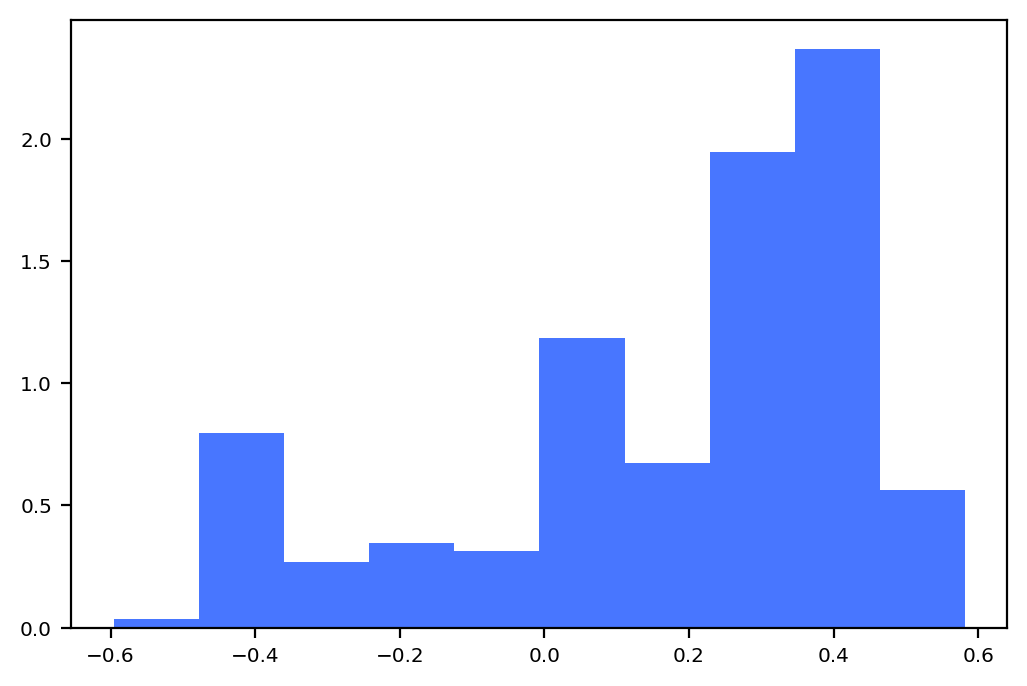

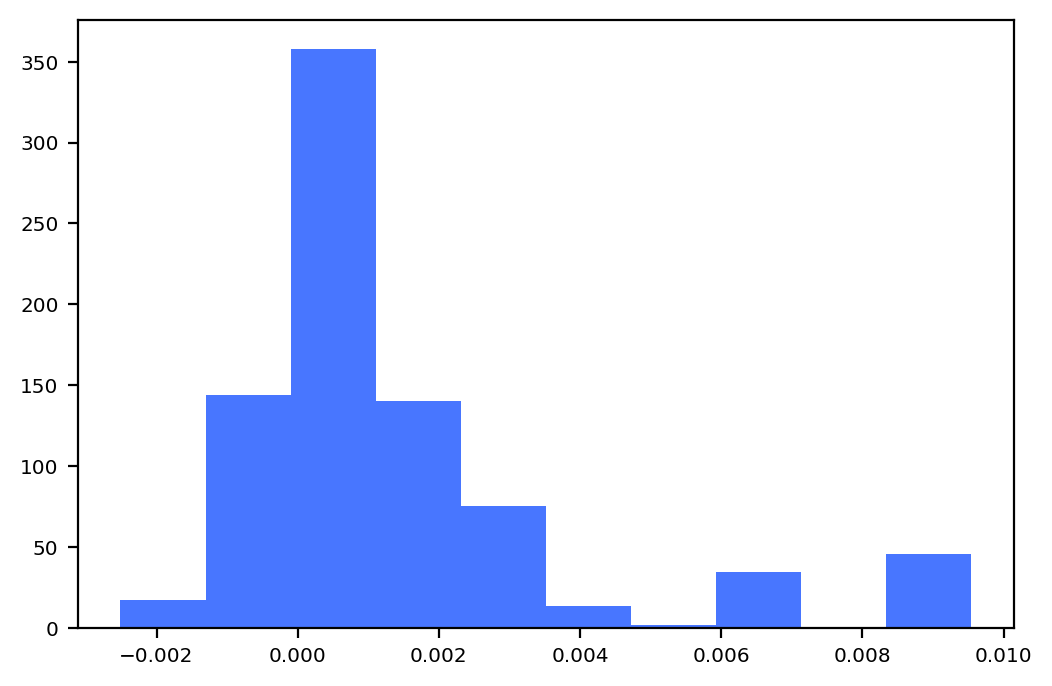

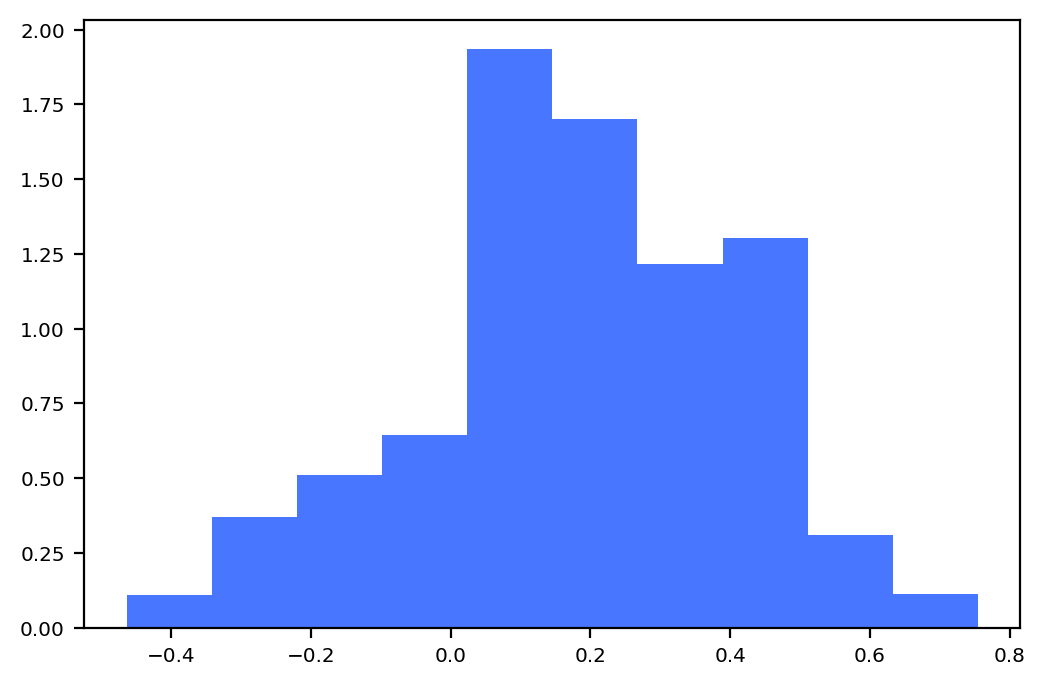

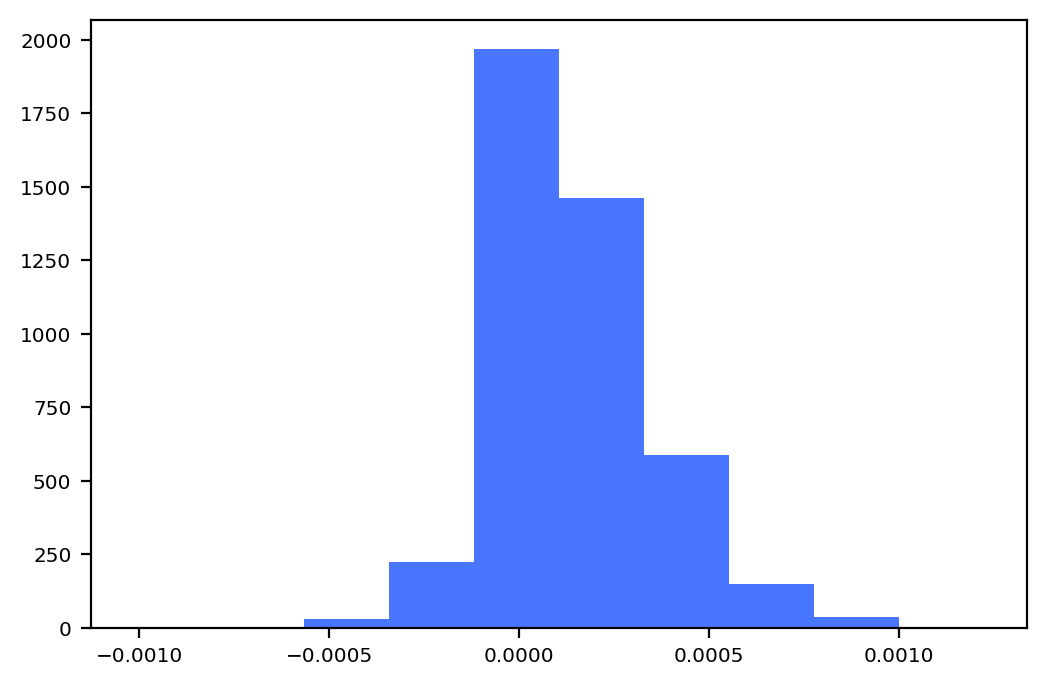

0.16956001341120316 0.2098033484086649 0.18210018207726497 0.07901236559667944 0.04717243926220622 0.049587961913571385
0.00149528796495243 0.0014671842766057442 0.0001415046319132126 6.563779927542358e-06 4.095134593306259e-06 4.192837055955376e-08


In [314]:
# latent相关系数计算引入内积结构

v_spz_fisher_latent = [[latent_z[spz_fisher[j][i+1]] - latent_z[spz_fisher[j][i]] for i in range(len(spz_fisher[j])-1)] for j in range(ng)]

corr_fisher_latent = []
inner_prod_fisher_latent = []
for j in range(ng):
    v_latent = velo_latent[spz_fisher[j][:-1]]
    for i in range(len(spz_fisher[j])-1):
        corr_fisher_latent.append(np.corrcoef(v_spz_fisher_latent[j][i]@(Fisher_g[spz_fisher[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_fisher[j][i]])**(1/2))[0,1])
        inner_prod_fisher_latent.append(np.dot(v_spz_fisher_latent[j][i]@(Fisher_g[spz_fisher[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_fisher[j][i]])**(1/2)))
        
plt.hist(np.array(corr_fisher_latent),density=True)
plt.savefig('corr_fisher_dist_latent_fisher.png')
plt.show()
plt.hist(np.array(inner_prod_fisher_latent),density=True)
plt.savefig('dot_fisher_dist_latent_fisher.png')
plt.show()


v_spz_euc_latent = [[latent_z[spz_euc[j][i+1]] - latent_z[spz_euc[j][i]] for i in range(len(spz_euc[j])-1)] for j in range(ng)]

corr_euc_latent = []
inner_prod_euc_latent = []
for j in range(ng):
    v_latent = velo_latent[spz_euc[j][:-1]]
    for i in range(len(spz_euc[j])-1):
        corr_euc_latent.append(np.corrcoef(v_spz_euc_latent[j][i]@(Fisher_g[spz_euc[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_euc[j][i]])**(1/2))[0,1])
        inner_prod_euc_latent.append(np.dot(v_spz_euc_latent[j][i]@(Fisher_g[spz_euc[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_euc[j][i]])**(1/2)))
plt.hist(np.array(corr_euc_latent),density=True)
plt.savefig('corr_euc_dist_latent_fisher.png')
plt.show()
plt.hist(np.array(inner_prod_euc_latent),density=True)
plt.savefig('dot_euc_dist_latent_fisher.png')
plt.show()


v_spz_action_latent = [[latent_z[spz_action[j][i+1]] - latent_z[spz_action[j][i]] for i in range(len(spz_action[j])-1)] for j in range(ng)]

corr_action_latent = []
inner_prod_action_latent = []
for j in range(ng):
    v_latent = velo_latent[spz_action[j][:-1]]
    for i in range(len(spz_action[j])-1):
        corr_action_latent.append(np.corrcoef(v_spz_action_latent[j][i]@(Fisher_g[spz_action[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_action[j][i]])**(1/2))[0,1])
        inner_prod_action_latent.append(np.dot(v_spz_action_latent[j][i]@(Fisher_g[spz_action[j][i]])**(1/2),v_latent[i]@(Fisher_g[spz_action[j][i]])**(1/2)))
plt.hist(np.array(corr_action_latent),density=True)
plt.savefig('corr_action_latent_fisher.png')
plt.show()
plt.hist(np.array(inner_prod_action_latent),density=True)
plt.savefig('dot_action_latent_fisher.png')
plt.show()

print(
    np.mean(corr_euc_latent), np.mean(corr_fisher_latent), np.mean(corr_action_latent),np.var(corr_euc_latent), np.var(corr_fisher_latent), np.var(corr_action_latent)
    )

print(
    np.mean(inner_prod_euc_latent), np.mean(inner_prod_fisher_latent), np.mean(inner_prod_action_latent),np.var(inner_prod_euc_latent), np.var(inner_prod_fisher_latent), np.var(inner_prod_action_latent)
    )

## **随机背景**  ##
随机在KNN上做一些路径，计算Corr    
按照概率论知识，相关系数应该是一个0均值，1/d方差的分布

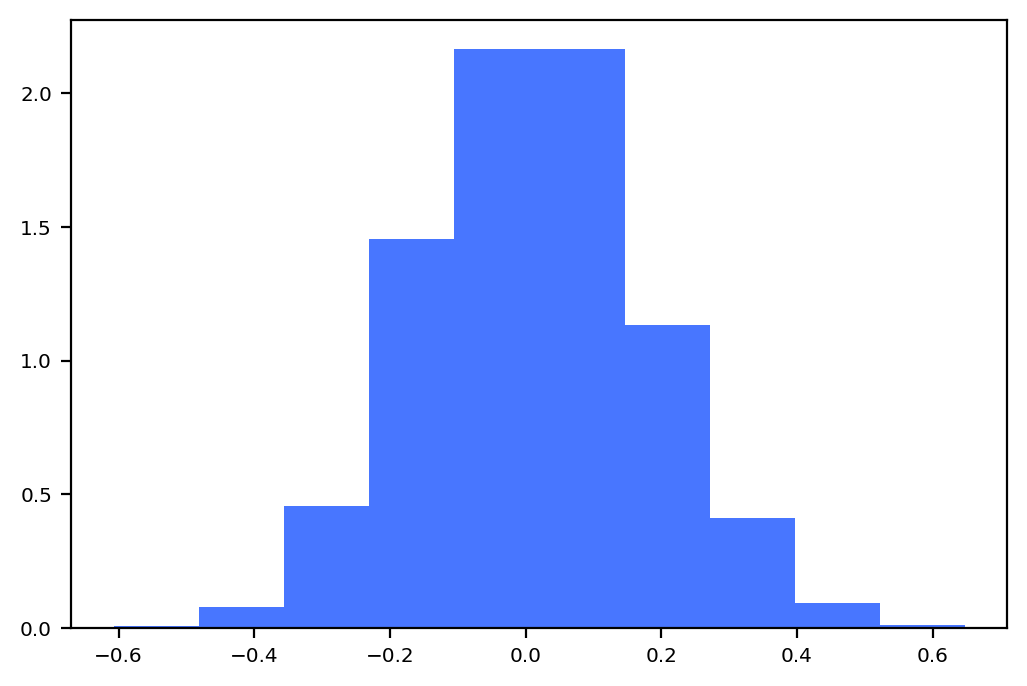

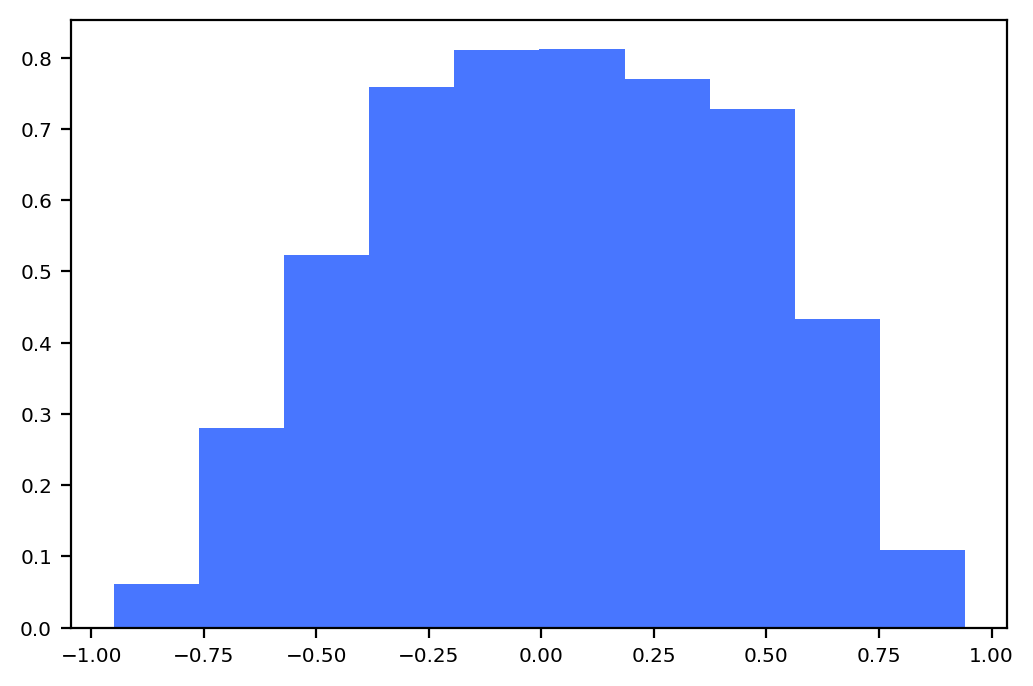

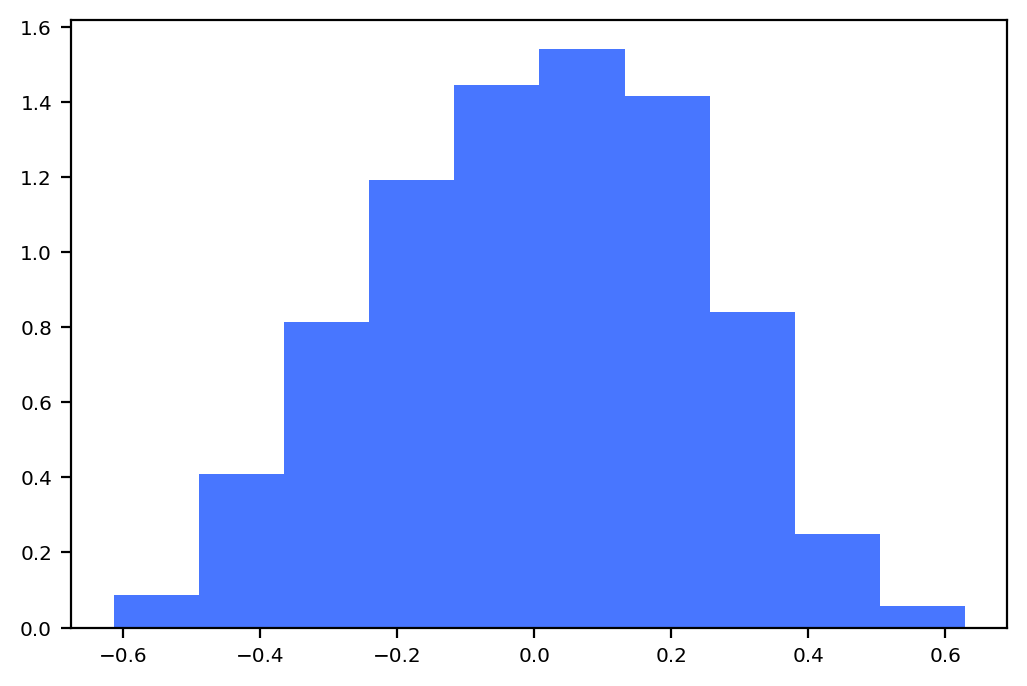

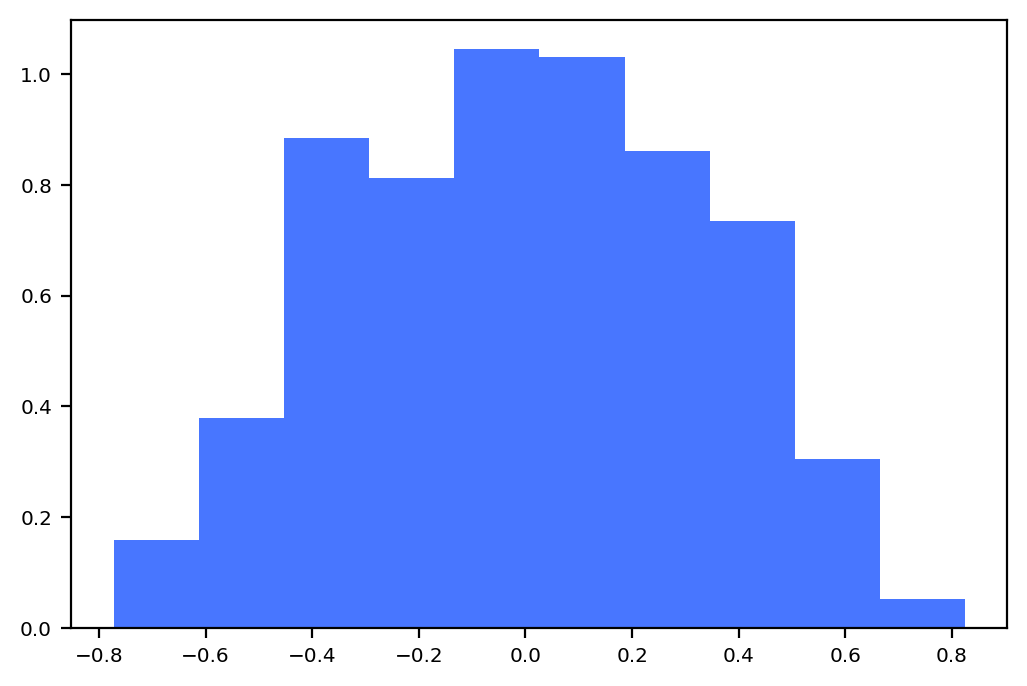

0.01183266793560548 0.04252112986802275 0.004499298792449925 0.00011497617175658448
0.027295840622042544 0.15478988976484043 0.05253341429120891 0.10716452117164847


In [316]:
# Random path on KNN
random_path = []
v_random = []
corr_random = []
corr_random_pca = []
corr_random_latent = []
corr_random_latent_fisher = []


for start in sources:
    now = start
    for k in range(30):
        neis = list(G.neighbors(now))
        neis.remove(now)
        nei = random.choice(neis)
        v_nei = X_pca[nei,:] - X_pca[now,:]
        v_nei_latent = latent_z[nei,:] - latent_z[now,:]
        

        corr_random.append(np.corrcoef(v_nei,velo_pca[now])[0,1])
        corr_random_pca.append(np.corrcoef(v_nei@np.real(scipy.linalg.sqrtm(Fisher_pca[now])),velo_pca[now]@np.real(scipy.linalg.sqrtm(Fisher_pca[now])))[0,1])
        corr_random_latent.append(np.corrcoef(v_nei_latent,velo_latent[now])[0,1])
        corr_random_latent_fisher.append(np.corrcoef(v_nei_latent@(Fisher_g[now])**(1/2),velo_latent[now]@(Fisher_g[now])**(1/2))[0,1])
        now = nei

plt.hist(np.array(corr_random),density=True)
plt.show()

plt.hist(np.array(corr_random_pca),density=True)
plt.show()

plt.hist(np.array(corr_random_latent),density=True)
plt.show()

plt.hist(np.array(corr_random_latent_fisher),density=True)
plt.show()

print(np.mean(corr_random), np.mean(corr_random_pca), np.mean(corr_random_latent),  np.mean(corr_random_latent_fisher))
print(np.var(corr_random), np.var(corr_random_pca), np.var(corr_random_latent),  np.var(corr_random_latent_fisher))

## **Action计算** ##

In [175]:
def compute_action(path):
    '''
    path: an array of node index
    '''
    # Compute action
    action = 0
    v = np.array([latent_z[path[i+1]] - latent_z[path[i]] for i in range(len(path)-1)])
    for i in range(len(path)-1):
        action += v[i,:].T @ Fisher_g[path[i]] @ v[i,:]
    return action

In [176]:
# Compute action
# action1 = 0
# for i in range(len(spz_fisher[0])-1):
#     action1 += v_sp[i,:] @ Fisher_pca[spz_fisher[0][i]] @ v_sp[i,:].T
# action1
for i in range(ng):
    print(compute_action(spz_fisher[i]), compute_action(spz_euc[i]), compute_action(spz_action[i]))

3.010757510635952 9.036809265121914 0.4418291462918394
2.8808440508696043 26.301361135710966 0.4838387619049686
9.4027538357805 9.498680792538272 0.5280814745123041
9.338260218046353 25.945589100777656 0.5348209756987164
2.568119406438278 9.099733259040333 0.4118803101555814
2.905362874079146 9.043824002861728 0.42946263044517197
9.315350676273304 9.405673413878327 0.5190983284588687
25.798741687223938 25.89466864398171 0.591128637221868
9.174211658616018 25.89261460555154 0.5201794238786964
9.284029710355682 25.97991543511693 0.5019625183627386
2.5112429071081213 9.039197485462019 0.43014495697599114
11.000693868377818 11.007002170167972 0.6623041020405015
2.4302612872817226 9.08853673182862 0.4108049170652174
9.421004383532708 25.867142622373642 0.5325016564113267
2.6693371509098593 9.477179032798405 0.4535633120001403
9.478957917367792 9.545283420295341 0.5209596617005591
2.3729999218210054 9.14296153332387 0.3972851809278599
9.504535227296808 9.910396492381855 0.5315674088365668
3.

## **按照RNA velo方向选路**

In [177]:
# DG start at 853
velo_path = []
v_velo = []
path_corr = []
now = np.array([np.random.choice(G.nodes) for _ in range(1)])[0]
velo_path.append(now)
for k in range(10):
    neis = list(G.neighbors(now))
    neis.remove(now)
    v_nei = X_pca[neis] - X_pca[now,:]
    corr = np.array([np.corrcoef(v_nei[i],velo_pca[now])[0,1] for i in range(len(neis))])
    now = neis[np.argmax(corr)]
    path_corr.append(np.max(corr))
    velo_path.append(now)

velo_path = np.array(velo_path)
path_corr = np.array(path_corr)
v_velo = np.array(v_velo)
velo_path,path_corr


(array([1820,  779, 2043,  779, 2043,  779, 2043,  779, 2043,  779, 2043]),
 array([0.23767313, 0.24316652, 0.08286661, 0.24316652, 0.08286661,
        0.24316652, 0.08286661, 0.24316652, 0.08286661, 0.24316652]))

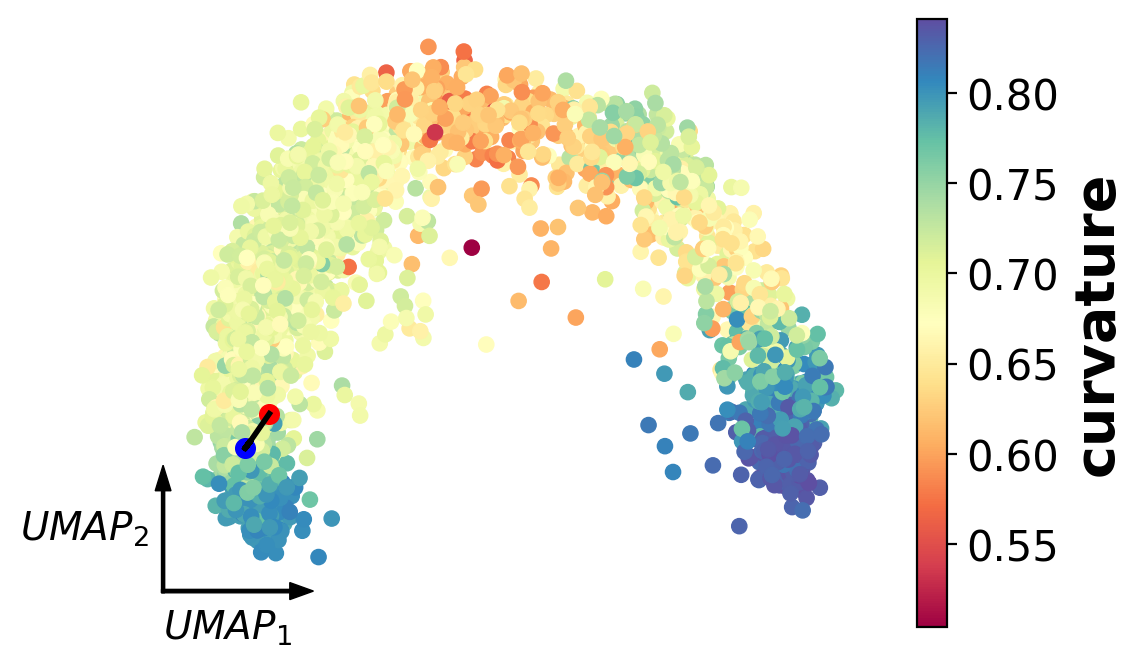

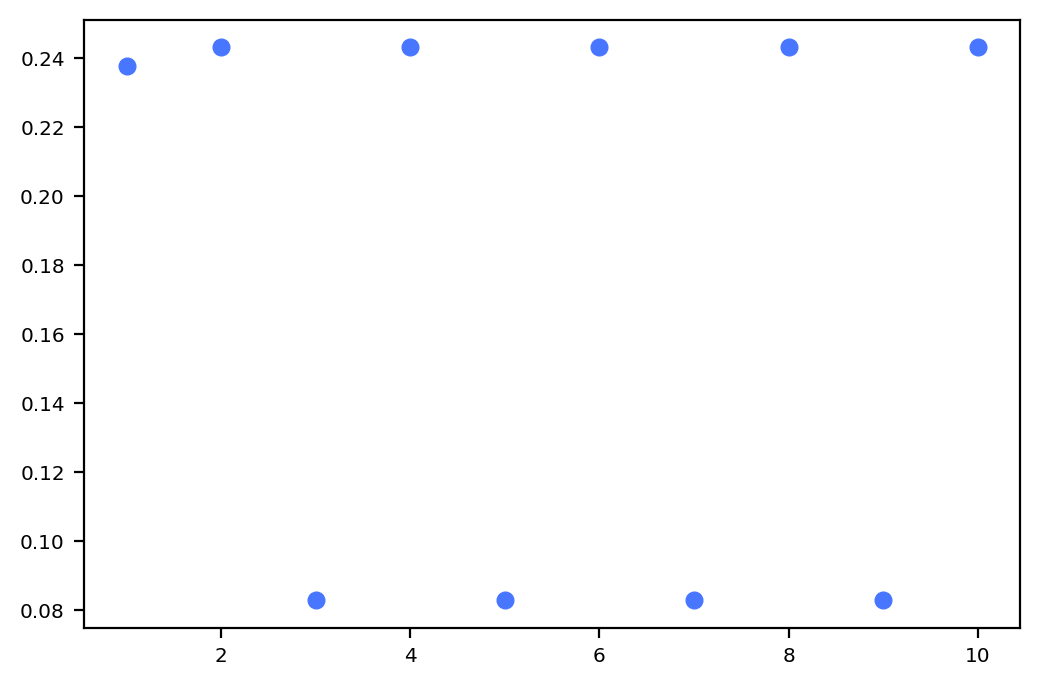

In [178]:
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')
plt.axis('off')
plt.plot(X_plt[velo_path],Y_plt[velo_path],c='black', linewidth=2)
plt.scatter(X_plt[velo_path[0]],Y_plt[velo_path[0]],s = 50, c='red')
plt.scatter(X_plt[velo_path[-1]],Y_plt[velo_path[-1]],s = 50, c='blue')



plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*25,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')

plt.show()
plt.scatter(np.linspace(1,path_corr.shape[0],path_corr.shape[0]), path_corr)

In [179]:
# Compute action
compute_action(velo_path)

0.5098362657150527

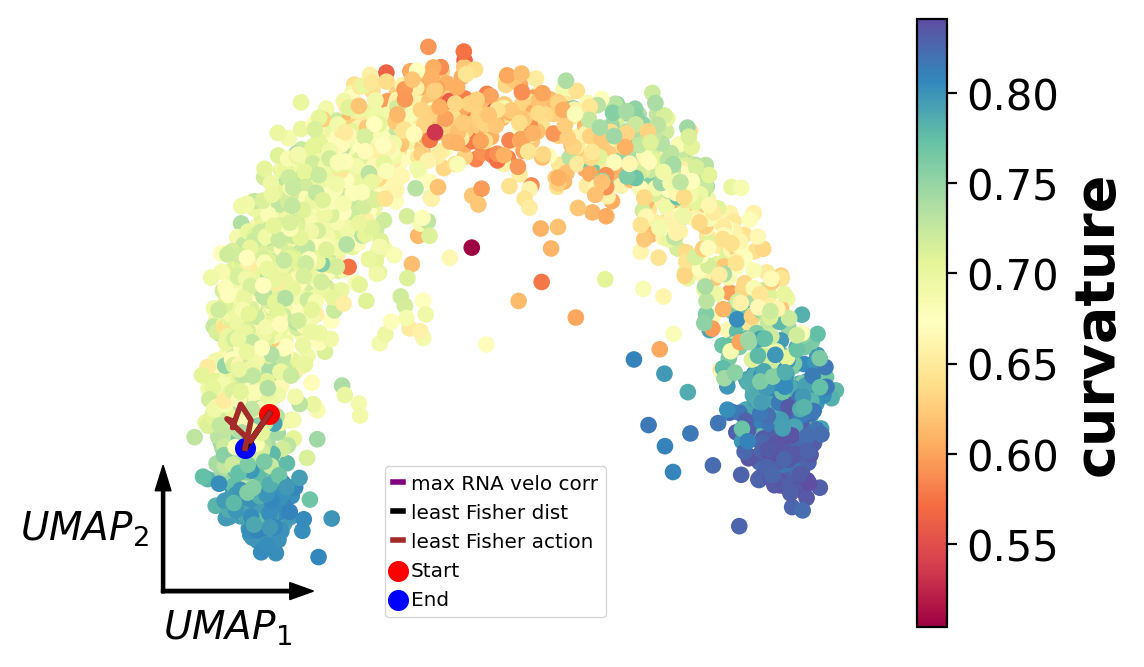

In [180]:
spz_fisher_velo_path = nx.shortest_path(G,source=velo_path[0],target=velo_path[-1],weight='dist_fisher')
spz_action_velo_path = nx.shortest_path(G,source=velo_path[0],target=velo_path[-1],weight='action')
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')
plt.axis('off')

plt.plot(X_plt[velo_path],Y_plt[velo_path],c='purple', linewidth=2, label='max RNA velo corr')
plt.plot(X_plt[spz_fisher_velo_path],Y_plt[spz_fisher_velo_path],c='black', linewidth=2, label='least Fisher dist')
plt.plot(X_plt[spz_action_velo_path],Y_plt[spz_action_velo_path],c='brown', linewidth=2, label='least Fisher action')
plt.scatter(X_plt[velo_path[0]],Y_plt[velo_path[0]],s = 50, c='red', label='Start')
plt.scatter(X_plt[velo_path[-1]],Y_plt[velo_path[-1]],s = 50, c='blue', label = 'End')
plt.legend(loc = 'best')



plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*25,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')

plt.savefig('max RNA corr path.png')
plt.show()

In [181]:
compute_action(velo_path), compute_action(spz_fisher_velo_path), compute_action(spz_action_velo_path)

(0.5098362657150527, 0.05686943779275685, 0.029565889972853684)

## **按照最大特征方向选路**

In [182]:
# eigen_path = []
# path_corr = []
# now = np.array([np.random.choice(G.nodes) for _ in range(1)])[0]
# eigen_path.append(now)
# for k in range(10):
#     neis = list(G.neighbors(now))
#     neis.remove(now)
#     v_nei = X_pca[neis] - X_pca[now,:]
#     corr = np.array([np.abs(np.corrcoef(v_nei[i],eigvecs_pca[now][:,0])[0,1]) for i in range(len(neis))])
#     now = neis[np.argmax(corr)]
#     path_corr.append(np.max(corr))
#     eigen_path.append(now)

# eigen_path = np.array(eigen_path)
# path_corr = np.array(path_corr)
# eigen_path,path_corr

In [183]:
# idx = ~np.isnan(crc_smooth)
# cmap = plt.colormaps['Spectral']
# plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
# plt.axis('off')
# plt.plot(X_plt[eigen_path],Y_plt[eigen_path],c='black', linewidth=2)
# plt.scatter(X_plt[eigen_path[0]],Y_plt[eigen_path[0]],s = 50, c='red')
# plt.scatter(X_plt[eigen_path[-1]],Y_plt[eigen_path[-1]],s = 50, c='blue')

# clb=plt.colorbar()
# clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
# clb.ax.tick_params(axis='y', labelsize=15)
# # plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')

# plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
# plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
# plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
# plt.text(X_ori-wid*17,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')

# plt.show()
# plt.scatter(np.linspace(1,path_corr.shape[0],path_corr.shape[0]), path_corr)

In [184]:
# compute_action(eigen_path)

In [185]:
# spz_eigen_velo_path = nx.shortest_path(G,source=eigen_path[0],target=eigen_path[-1],weight='Fisher dist')
# idx = ~np.isnan(crc_smooth)
# cmap = plt.colormaps['Spectral']
# plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
# plt.axis('off')
# plt.plot(X_plt[spz_eigen_velo_path],Y_plt[spz_eigen_velo_path],c='black', linewidth=2)
# plt.scatter(X_plt[spz_eigen_velo_path[0]],Y_plt[spz_eigen_velo_path[0]],s = 50, c='red')
# plt.scatter(X_plt[spz_eigen_velo_path[-1]],Y_plt[spz_eigen_velo_path[-1]],s = 50, c='blue')

# clb=plt.colorbar()
# clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
# clb.ax.tick_params(axis='y', labelsize=15)
# # plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')

# plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
# plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
# plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
# plt.text(X_ori-wid*17,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')

# plt.show()

In [186]:
# compute_action(spz_eigen_velo_path)

## **接下来在latent space上做，看看是否Velo和Action有很好的相关性**

In [187]:
# DG try 51 -> 2003, or start at 853
velo_path = []
v_velo = []
path_corr = []
# now = np.array([np.random.choice(G.nodes) for _ in range(1)])[0]
now = 51
velo_path.append(now)
for k in range(10):
    neis = list(G.neighbors(now))
    neis.remove(now)
    v_nei = latent_z[neis] - latent_z[now,:]
    corr = np.array([np.corrcoef(v_nei[i],velo_latent[now])[0,1] for i in range(len(neis))])
    # corr = np.array([np.dot(v_nei[i],velo_latent[now]) for i in range(len(neis))])
    now = neis[np.argmax(corr)]
    if now in velo_path:
        break

    path_corr.append(np.max(corr))
    velo_path.append(now)

velo_path = np.array(velo_path)
path_corr = np.array(path_corr)
v_velo = np.array(v_velo)
spz_fisher_velo_path = nx.shortest_path(G,source=velo_path[0],target=velo_path[-1],weight='dist_fisher')
spz_action = nx.shortest_path(G,source=velo_path[0],target=velo_path[-1],weight='action')
velo_path,spz_fisher_velo_path,np.array(spz_action),compute_action(velo_path),compute_action(spz_fisher_velo_path),compute_action(spz_action)

(array([  51, 2405, 1595, 1176,  421,   23, 2657, 2292, 1807,  425, 1669]),
 [51, 1551, 1226, 891, 2674, 1669],
 array([  51, 1551, 2192, 2796,  612, 2832,  309, 1642,  933, 2866, 2132,
        1059,  695, 2908,  891, 1076,  354, 2003, 1800,  604,  560, 1682,
        1910, 1669]),
 0.7078563536477975,
 0.3225406261324827,
 0.10900334966651161)

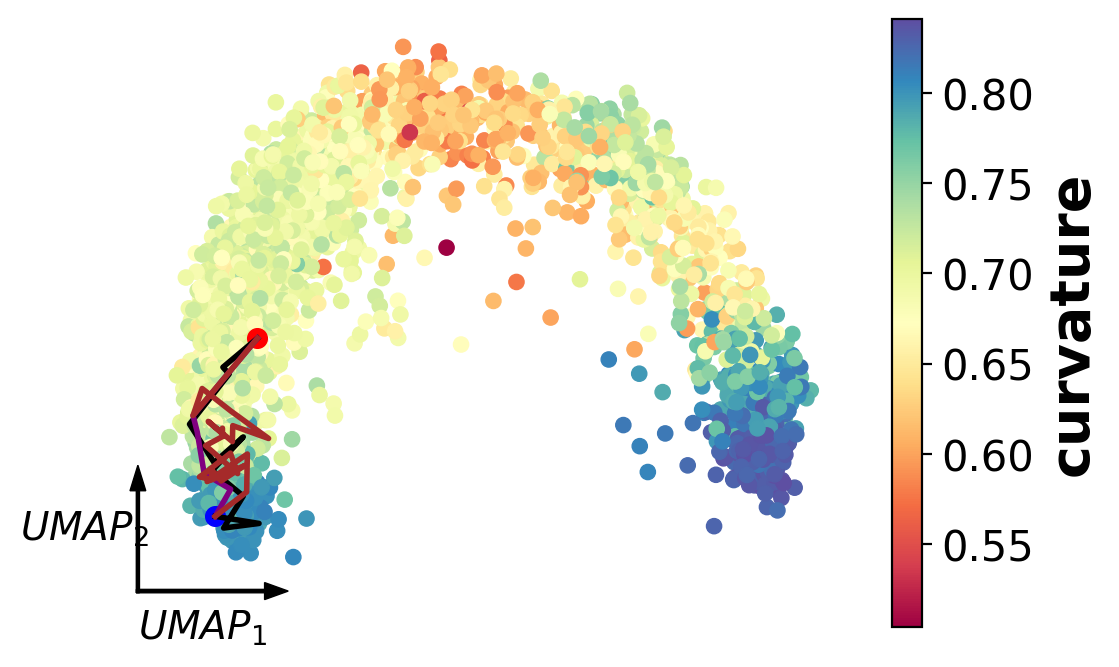

In [188]:
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
plt.axis('off')
plt.plot(X_plt[velo_path],Y_plt[velo_path],c='black', linewidth=2)


clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$UMAP_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*17,Y_ori+Y_len/2,'$UMAP_2$',fontsize=14,ha='center',weight='bold')

####################################################3
plt.plot(X_plt[spz_fisher_velo_path],Y_plt[spz_fisher_velo_path],c='purple', linewidth=2)
plt.plot(X_plt[spz_action],Y_plt[spz_action],c='brown', linewidth=2)
plt.scatter(X_plt[spz_fisher_velo_path[0]],Y_plt[spz_fisher_velo_path[0]],s = 50, c='red')
plt.scatter(X_plt[spz_fisher_velo_path[-1]],Y_plt[spz_fisher_velo_path[-1]],s = 50, c='blue')


plt.show()